In [1]:
!pip install bayesian-optimization

In [2]:
import numpy as np
import pandas as pd
from google.colab import drive

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns

from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

In [3]:
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Ruta al archivo CSV
#file_path = '/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/Datos/historico_completo.csv'
file_path = '/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/Datos/datos_2024/ocupacion_2024.csv'
# Leer el archivo CSV
ocupacion_historica = pd.read_csv(file_path)

# Mostrar los primeros registros
ocupacion_historica.head()

id  cod_empresa  linea_codigo  sevar_codigo         dia  \
0  20240101           50            76          3267  2024-01-01   
1  20240101           50            78          4016  2024-01-01   
2  20240101           50            45          3983  2024-01-01   
3  20240101           50            45          3973  2024-01-01   
4  20240101           50            40          7883  2024-01-01   

   franja_horaria  ascensos_promedio  ocupacion_promedio  \
0              84                5.0            0.916667   
1              88                5.0            1.709091   
2              89                3.0            0.690476   
3              90                3.0            0.482759   
4              90                1.0            0.272727   

   ocupacion_maxima_promedio  ocupacion_maxima  cantidad              tipo_dia  
0                        4.0                 4         1  FERIADO NO LABORABLE  
1                        5.0                 5         1  FERIADO NO LABORABLE  
2                        3.0                 3         1  FERIADO NO LABORABLE  
3                        2.0                 2         1  FERIADO NO LABORABLE  
4                        1.0                 1         1  FERIADO NO LABORABLE

In [5]:
#precipitaciones = pd.read_csv('/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/Datos/pluviometros.csv')
precipitaciones = pd.read_csv('/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/Datos/datos_2024/acc_2024_2.csv',
                              encoding='latin-1')
precipitaciones.head()

nombre                       fecha  instant_precipitation  ac_15  ac_1440
0  Capurro  2024-01-01T00:00:00.000-03                    0.0    0.0      0.0
1  Capurro  2024-01-01T00:05:00.000-03                    0.0    0.0      0.0
2  Capurro  2024-01-01T00:10:00.000-03                    0.0    0.0      0.0
3  Capurro  2024-01-01T00:15:00.000-03                    0.0    0.0      0.0
4  Capurro  2024-01-01T00:20:00.000-03                    0.0    0.0      0.0

In [6]:
# fecha a tipo datetime
precipitaciones['fecha'] = pd.to_datetime(precipitaciones['fecha'])

# Establecer 'fecha' como índice
precipitaciones.set_index('fecha', inplace=True)

# Agrupar por ubicación y "resamplear" en intervalos de 1 hora, sumando la precipitación
df_por_estacion_hora = (
    precipitaciones
    .groupby('nombre')
    .resample('H')['ac_15']
    .sum()
)

<ipython-input-6-9efc2056658d>:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')['ac_15']


In [7]:
# volver a convertir el índice en columna y renombrar
df_por_estacion_hora = df_por_estacion_hora.reset_index()
df_por_estacion_hora.rename(columns={'ac_15': 'precipitacion_1h'}, inplace=True)

In [8]:
#se promedian las precipitaciones entre todfas las estaciones en cada hora
df_promedio_hora = (
    df_por_estacion_hora
    .groupby('fecha')['precipitacion_1h']
    .mean()  # Promedio entre las 15 estaciones
    .reset_index()
)

In [9]:
# extraer día y hora cerrada
df_promedio_hora['dia'] = df_promedio_hora['fecha'].dt.date          # Extrae la fecha (AAAA-MM-DD)
df_promedio_hora['hora_cerrada'] = df_promedio_hora['fecha'].dt.hour # Extrae la hora (0 a 23)

In [10]:
df_promedio_hora.head()

fecha  precipitacion_1h         dia  hora_cerrada
0 2024-01-01 00:00:00-03:00               0.0  2024-01-01             0
1 2024-01-01 01:00:00-03:00               0.0  2024-01-01             1
2 2024-01-01 02:00:00-03:00               0.0  2024-01-01             2
3 2024-01-01 03:00:00-03:00               0.0  2024-01-01             3
4 2024-01-01 04:00:00-03:00               0.0  2024-01-01             4

In [11]:
#Cantidad de valores de ocupacion_promedio menores a 0
cantidad = (ocupacion_historica['ocupacion_promedio'] < 0).sum()
print(cantidad)

25102


In [12]:
#Convierto todos los valores de ocupacion_promedio menores a 0 en 0 para corregir los datos según lo explicado por los técnicos de IM
ocupacion_historica.loc[ocupacion_historica['ocupacion_promedio'] < 0, 'ocupacion_promedio'] = 0

In [13]:
print(ocupacion_historica.tipo_dia.unique().tolist())

['FERIADO NO LABORABLE', 'HABIL', 'FERIADO LABORABLE', 'TIPO DOMINGO', 'TIPO SABADO', 'DIA DE LOS MUNICIPIOS DE AMERICA']


In [14]:
#se cambia el día de los municipios de america a día hábil, porque ese es un día normal para el transporte
ocupacion_historica.loc[ocupacion_historica['tipo_dia'] == 'DIA DE LOS MUNICIPIOS DE AMERICA', 'tipo_dia'] = 'HABIL'
print(ocupacion_historica.tipo_dia.unique().tolist())

['FERIADO NO LABORABLE', 'HABIL', 'FERIADO LABORABLE', 'TIPO DOMINGO', 'TIPO SABADO']


In [15]:
#se crea nueva columna dividiendo entre 4 la franja_horaria, eso nos da la hora
ocupacion_historica['hora'] = ocupacion_historica['franja_horaria']/4
ocupacion_historica.head()

id  cod_empresa  linea_codigo  sevar_codigo         dia  \
0  20240101           50            76          3267  2024-01-01   
1  20240101           50            78          4016  2024-01-01   
2  20240101           50            45          3983  2024-01-01   
3  20240101           50            45          3973  2024-01-01   
4  20240101           50            40          7883  2024-01-01   

   franja_horaria  ascensos_promedio  ocupacion_promedio  \
0              84                5.0            0.916667   
1              88                5.0            1.709091   
2              89                3.0            0.690476   
3              90                3.0            0.482759   
4              90                1.0            0.272727   

   ocupacion_maxima_promedio  ocupacion_maxima  cantidad  \
0                        4.0                 4         1   
1                        5.0                 5         1   
2                        3.0                 3         1   
3                        2.0                 2         1   
4                        1.0                 1         1   

               tipo_dia   hora  
0  FERIADO NO LABORABLE  21.00  
1  FERIADO NO LABORABLE  22.00  
2  FERIADO NO LABORABLE  22.25  
3  FERIADO NO LABORABLE  22.50  
4  FERIADO NO LABORABLE  22.50

In [16]:
ocupacion_historica['hora'].unique()

array([21.  , 22.  , 22.25, 22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75,
        0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.25, 21.5 , 21.75])

In [17]:
#vamos a redondear hacia abajo las horas, para luego considerar el promedio por hora cerrada, ejemplo 0.15 se pone como 0 hs
ocupacion_historica['hora_cerrada'] = np.floor(ocupacion_historica['hora']).astype(int)

In [18]:
ocupacion_historica['fecha'] = pd.to_datetime(ocupacion_historica['dia'])
ocupacion_historica['fecha'] = ocupacion_historica['fecha'].dt.date

In [19]:
df_ocupacion_hora = ocupacion_historica.groupby(['dia', 'hora_cerrada', 'linea_codigo', 'tipo_dia'])['ocupacion_promedio'].mean()

# Convertimos a DataFrame normal con reset_index
df_ocupacion_hora = df_ocupacion_hora.reset_index()

In [20]:
df_ocupacion_hora.head()

dia  hora_cerrada  linea_codigo              tipo_dia  \
0  2024-01-01            21            76  FERIADO NO LABORABLE   
1  2024-01-01            22            40  FERIADO NO LABORABLE   
2  2024-01-01            22            45  FERIADO NO LABORABLE   
3  2024-01-01            22            76  FERIADO NO LABORABLE   
4  2024-01-01            22            78  FERIADO NO LABORABLE   

   ocupacion_promedio  
0            0.916667  
1            0.272727  
2            0.586617  
3            2.404762  
4            1.709091

In [21]:
ocupacion_hora_linea = df_ocupacion_hora.groupby('linea_codigo')["ocupacion_promedio"].mean()
linea_mayor_ocupacion = ocupacion_hora_linea.idxmax()
# Recuperar el valor de esa ocupación promedio
valor_mayor_ocupacion = ocupacion_hora_linea[linea_mayor_ocupacion]
print(f"La línea con mayor ocupación promedio es la {linea_mayor_ocupacion}, con un valor de {valor_mayor_ocupacion}")

La línea con mayor ocupación promedio es la 504, con un valor de 21.013582697794824


In [22]:
top_3_lineas = ocupacion_hora_linea.nlargest(3)
print(top_3_lineas)

linea_codigo
504    21.013583
20     20.969529
88     20.857272
Name: ocupacion_promedio, dtype: float64


In [23]:
### Top 3 de las 3 lineas con mayor maximo_
top_3 = ocupacion_historica.nlargest(3, 'ocupacion_maxima')
print(top_3)

              id  cod_empresa  linea_codigo  sevar_codigo         dia  \
276438  20240131           10           497          8802  2024-01-31   
321389  20240205           10             2            20  2024-02-05   
325646  20240205           10             7          8533  2024-02-05   

        franja_horaria  ascensos_promedio  ocupacion_promedio  \
276438              50              136.0           36.285714   
321389              35              145.0           52.032258   
325646              61              100.5           24.254701   

        ocupacion_maxima_promedio  ocupacion_maxima  cantidad tipo_dia   hora  \
276438                      100.0               100         1    HABIL  12.50   
321389                      100.0               100         1    HABIL   8.75   
325646                       64.0               100         2    HABIL  15.25   

        hora_cerrada       fecha  
276438            12  2024-01-31  
321389             8  2024-02-05  
325646          

In [24]:
# Obtiene las 3 líneas con menor ocupación promedio
lineas_menor_3 = ocupacion_hora_linea.nsmallest(3)

print("Las tres líneas con menor ocupación promedio son:")
print(lineas_menor_3)

Las tres líneas con menor ocupación promedio son:
linea_codigo
507    1.282313
425    1.599855
503    1.905389
Name: ocupacion_promedio, dtype: float64


In [25]:
df_ocupacion_hora['dia'] = pd.to_datetime(df_ocupacion_hora['dia']).dt.date
df_promedio_hora['dia'] = pd.to_datetime(df_promedio_hora['dia']).dt.date
df_ocupacion_hora['hora_cerrada'] = df_ocupacion_hora['hora_cerrada'].astype('int64')
df_promedio_hora['hora_cerrada'] = df_promedio_hora['hora_cerrada'].astype('int64')

In [26]:
# Se unen los nuevos datos agrupados de las precipitaciones y de la ocupación
datos_combinados = pd.merge(
    df_ocupacion_hora,
    df_promedio_hora,
    on=['dia', 'hora_cerrada']
)
datos_combinados.head()

dia  hora_cerrada  linea_codigo              tipo_dia  \
0  2024-01-01            21            76  FERIADO NO LABORABLE   
1  2024-01-01            22            40  FERIADO NO LABORABLE   
2  2024-01-01            22            45  FERIADO NO LABORABLE   
3  2024-01-01            22            76  FERIADO NO LABORABLE   
4  2024-01-01            22            78  FERIADO NO LABORABLE   

   ocupacion_promedio                     fecha  precipitacion_1h  
0            0.916667 2024-01-01 21:00:00-03:00               0.0  
1            0.272727 2024-01-01 22:00:00-03:00               0.0  
2            0.586617 2024-01-01 22:00:00-03:00               0.0  
3            2.404762 2024-01-01 22:00:00-03:00               0.0  
4            1.709091 2024-01-01 22:00:00-03:00               0.0

In [27]:
datos_combinados['dia'] = pd.to_datetime(datos_combinados['dia'])
datos_combinados["mes"] = datos_combinados["dia"].dt.month
datos_combinados["dia_semana"] = datos_combinados["dia"].dt.weekday

In [28]:
datos_combinados.head()

dia  hora_cerrada  linea_codigo              tipo_dia  \
0 2024-01-01            21            76  FERIADO NO LABORABLE   
1 2024-01-01            22            40  FERIADO NO LABORABLE   
2 2024-01-01            22            45  FERIADO NO LABORABLE   
3 2024-01-01            22            76  FERIADO NO LABORABLE   
4 2024-01-01            22            78  FERIADO NO LABORABLE   

   ocupacion_promedio                     fecha  precipitacion_1h  mes  \
0            0.916667 2024-01-01 21:00:00-03:00               0.0    1   
1            0.272727 2024-01-01 22:00:00-03:00               0.0    1   
2            0.586617 2024-01-01 22:00:00-03:00               0.0    1   
3            2.404762 2024-01-01 22:00:00-03:00               0.0    1   
4            1.709091 2024-01-01 22:00:00-03:00               0.0    1   

   dia_semana  
0           0  
1           0  
2           0  
3           0  
4           0

In [29]:
# Se filtra una línea específica
linea_especifica = 504
datos_filtrados = datos_combinados[datos_combinados['linea_codigo'] == linea_especifica]

In [30]:
# Para la hora (24 horas)
datos_filtrados['hora_sin'] = np.sin(2 * np.pi * datos_filtrados['hora_cerrada'] / 24)
datos_filtrados['hora_cos'] = np.cos(2 * np.pi * datos_filtrados['hora_cerrada'] / 24)

# Para el mes (12 meses)
datos_filtrados['mes_sin'] = np.sin(2 * np.pi * (datos_filtrados['mes'] - 1) / 12)
datos_filtrados['mes_cos'] = np.cos(2 * np.pi * (datos_filtrados['mes'] - 1) / 12)

<ipython-input-30-6c75331f1b55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados['hora_sin'] = np.sin(2 * np.pi * datos_filtrados['hora_cerrada'] / 24)
<ipython-input-30-6c75331f1b55>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados['hora_cos'] = np.cos(2 * np.pi * datos_filtrados['hora_cerrada'] / 24)
<ipython-input-30-6c75331f1b55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [31]:
# Para el día de la semana (7 días)
datos_filtrados['dia_semana_sin'] = np.sin(2 * np.pi * datos_filtrados['dia_semana'] / 7)
datos_filtrados['dia_semana_cos'] = np.cos(2 * np.pi * datos_filtrados['dia_semana'] / 7)

<ipython-input-31-19ba055e1f34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados['dia_semana_sin'] = np.sin(2 * np.pi * datos_filtrados['dia_semana'] / 7)
<ipython-input-31-19ba055e1f34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados['dia_semana_cos'] = np.cos(2 * np.pi * datos_filtrados['dia_semana'] / 7)


In [32]:
datos_filtrados.head()

dia  hora_cerrada  linea_codigo tipo_dia  ocupacion_promedio  \
479  2024-01-02             6           504    HABIL           11.269795   
604  2024-01-02             7           504    HABIL           13.688172   
728  2024-01-02             8           504    HABIL           12.734115   
850  2024-01-02             9           504    HABIL            0.454545   
1587 2024-01-02            15           504    HABIL           27.571429   

                         fecha  precipitacion_1h  mes  dia_semana  hora_sin  \
479  2024-01-02 06:00:00-03:00               0.0    1           1  1.000000   
604  2024-01-02 07:00:00-03:00               0.0    1           1  0.965926   
728  2024-01-02 08:00:00-03:00               0.0    1           1  0.866025   
850  2024-01-02 09:00:00-03:00               0.0    1           1  0.707107   
1587 2024-01-02 15:00:00-03:00               0.0    1           1 -0.707107   

          hora_cos  mes_sin  mes_cos  dia_semana_sin  dia_semana_cos  
479   6.123234e-17      0.0      1.0        0.781831         0.62349  
604  -2.588190e-01      0.0      1.0        0.781831         0.62349  
728  -5.000000e-01      0.0      1.0        0.781831         0.62349  
850  -7.071068e-01      0.0      1.0        0.781831         0.62349  
1587 -7.071068e-01      0.0      1.0        0.781831         0.62349

In [33]:
# hacemos one hot en columna categorica
datos_filtrados = pd.get_dummies(datos_filtrados, columns=['tipo_dia'], prefix='tipo_dia')

In [34]:
datos_filtrados.head()

dia  hora_cerrada  linea_codigo  ocupacion_promedio  \
479  2024-01-02             6           504           11.269795   
604  2024-01-02             7           504           13.688172   
728  2024-01-02             8           504           12.734115   
850  2024-01-02             9           504            0.454545   
1587 2024-01-02            15           504           27.571429   

                         fecha  precipitacion_1h  mes  dia_semana  hora_sin  \
479  2024-01-02 06:00:00-03:00               0.0    1           1  1.000000   
604  2024-01-02 07:00:00-03:00               0.0    1           1  0.965926   
728  2024-01-02 08:00:00-03:00               0.0    1           1  0.866025   
850  2024-01-02 09:00:00-03:00               0.0    1           1  0.707107   
1587 2024-01-02 15:00:00-03:00               0.0    1           1 -0.707107   

          hora_cos  mes_sin  mes_cos  dia_semana_sin  dia_semana_cos  \
479   6.123234e-17      0.0      1.0        0.781831         0.62349   
604  -2.588190e-01      0.0      1.0        0.781831         0.62349   
728  -5.000000e-01      0.0      1.0        0.781831         0.62349   
850  -7.071068e-01      0.0      1.0        0.781831         0.62349   
1587 -7.071068e-01      0.0      1.0        0.781831         0.62349   

      tipo_dia_HABIL  
479             True  
604             True  
728             True  
850             True  
1587            True

In [35]:
datos_filtrados.columns

Index(['dia', 'hora_cerrada', 'linea_codigo', 'ocupacion_promedio', 'fecha',
       'precipitacion_1h', 'mes', 'dia_semana', 'hora_sin', 'hora_cos',
       'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
       'tipo_dia_HABIL'],
      dtype='object')

In [36]:
# Elegimos las columnas finales para X
feature_cols = [
    'hora_sin', 'hora_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'mes_sin', 'mes_cos',
    'precipitacion_1h'
]

# (Opcional) si incluiste linea_codigo en one-hot, igual logic
linea_cols = [col for col in datos_filtrados.columns if col.startswith('linea_')]
feature_cols.extend(linea_cols)

# Definimos X e y
X = datos_filtrados[feature_cols].copy()
y = datos_filtrados['ocupacion_promedio'].values
fechas = datos_filtrados[['dia', 'hora_cerrada']]  # Guardamos la fecha para poder graficar posteriormente

In [37]:
scaler = StandardScaler()

# Identificamos qué columnas en X son numéricas continuas y no están ya en [-1,1]
numeric_cols = ['precipitacion_1h']

# Ajustamos y transformamos
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [38]:
X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
    X, y, fechas, test_size=0.2, random_state=42
)

In [39]:
fecha_test['dia'] = pd.to_datetime(fecha_test['dia'], format="%Y-%m-%d")

# Convertimos la hora (0..23) a un Timedelta y la sumamos a la fecha
fecha_test['fecha_completa'] = fecha_test['dia'] + (pd.to_timedelta(fecha_test['hora_cerrada'], unit='h'))

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 741.4193 - mae: 20.6027 - val_loss: 100.0514 - val_mae: 8.1614
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 202.4759 - mae: 11.4477 - val_loss: 99.4734 - val_mae: 8.1207
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 165.1866 - mae: 10.2676 - val_loss: 109.0163 - val_mae: 8.7632
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 148.3210 - mae: 9.7356 - val_loss: 116.2539 - val_mae: 9.1431
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 139.9249 - mae: 9.5030 - val_loss: 118.1504 - val_mae: 9.2371
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 132.1986 - mae: 9.0754 - val_loss: 137.1311 - val_mae: 10.1126
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 125.3459 - mae: 9.1670 - val_loss: 107.6744 - val_mae: 8.6876
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 122.9788 - mae: 8.8308 - val_loss: 113.2867 - val_mae: 8.9928
Epoch 9/500
36/36 ━━━━━━━━━━━━━━━━━━━

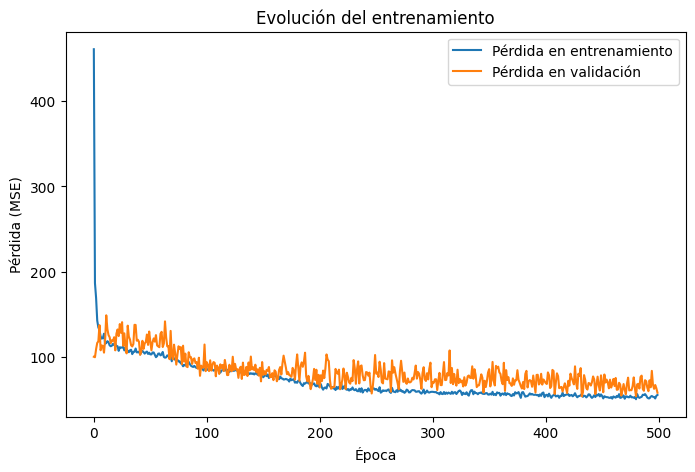

In [40]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # Salida de regresión
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,  # si quieres un split interno de validación
    epochs=500, #2000
    batch_size=32
)


# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

In [41]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {loss}, Test MAE: {mae}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.2731 - mae: 7.0931 
Test MSE: 82.94792938232422, Test MAE: 7.20256233215332


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


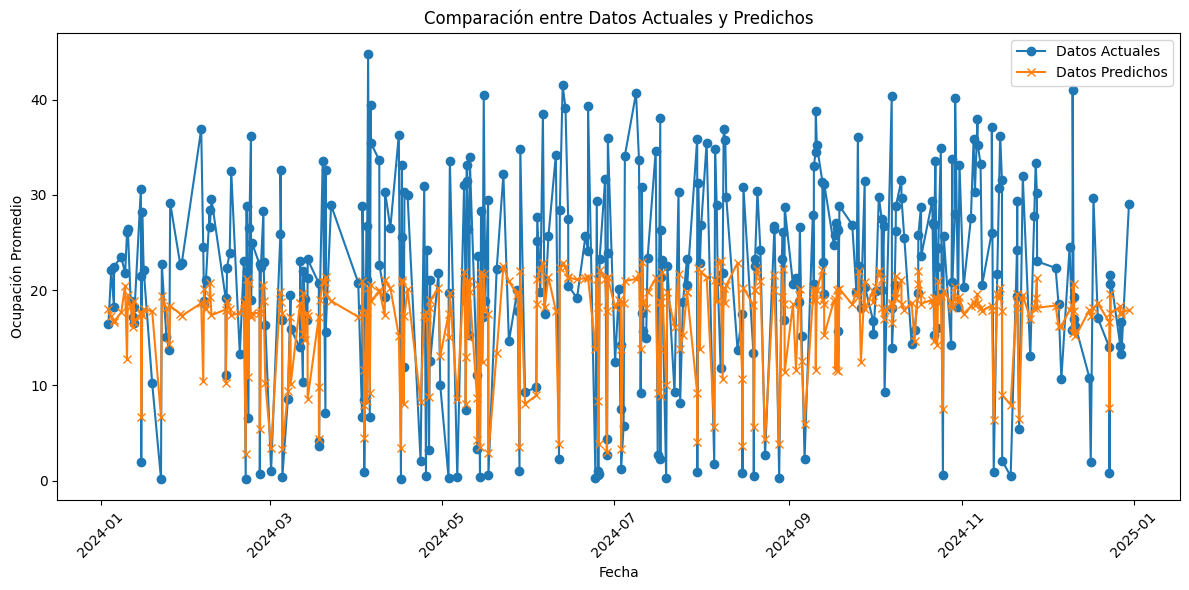

In [42]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': pd.to_datetime(fecha_test['dia'].astype(str)+ ' ' + fecha_test[ 'hora_cerrada'].astype(str)),
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# Se filtra una línea específica
linea_especifica2 = 20
datos_filtrados2 = datos_combinados[datos_combinados['linea_codigo'] == linea_especifica2]

# Para la hora (24 horas)
datos_filtrados2['hora_sin'] = np.sin(2 * np.pi * datos_filtrados2['hora_cerrada'] / 24)
datos_filtrados2['hora_cos'] = np.cos(2 * np.pi * datos_filtrados2['hora_cerrada'] / 24)

# Para el mes (12 meses)
datos_filtrados2['mes_sin'] = np.sin(2 * np.pi * (datos_filtrados2['mes'] - 1) / 12)
datos_filtrados2['mes_cos'] = np.cos(2 * np.pi * (datos_filtrados2['mes'] - 1) / 12)

# Para el día de la semana (7 días)
datos_filtrados2['dia_semana_sin'] = np.sin(2 * np.pi * datos_filtrados2['dia_semana'] / 7)
datos_filtrados2['dia_semana_cos'] = np.cos(2 * np.pi * datos_filtrados2['dia_semana'] / 7)

# hacemos one hot en columna categorica
datos_filtrados2 = pd.get_dummies(datos_filtrados2, columns=['tipo_dia'], prefix='tipo_dia')

<ipython-input-43-124803397be0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados2['hora_sin'] = np.sin(2 * np.pi * datos_filtrados2['hora_cerrada'] / 24)
<ipython-input-43-124803397be0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados2['hora_cos'] = np.cos(2 * np.pi * datos_filtrados2['hora_cerrada'] / 24)
<ipython-input-43-124803397be0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [44]:
datos_filtrados2.head()

dia  hora_cerrada  linea_codigo  ocupacion_promedio  \
39  2024-01-02             0            20            2.800000   
82  2024-01-02             1            20            2.459016   
127 2024-01-02             2            20            2.400000   
166 2024-01-02             3            20            1.015385   
202 2024-01-02             4            20           14.415893   

                        fecha  precipitacion_1h  mes  dia_semana  hora_sin  \
39  2024-01-02 00:00:00-03:00               0.0    1           1  0.000000   
82  2024-01-02 01:00:00-03:00               0.0    1           1  0.258819   
127 2024-01-02 02:00:00-03:00               0.0    1           1  0.500000   
166 2024-01-02 03:00:00-03:00               0.0    1           1  0.707107   
202 2024-01-02 04:00:00-03:00               0.0    1           1  0.866025   

     hora_cos  mes_sin  mes_cos  dia_semana_sin  dia_semana_cos  \
39   1.000000      0.0      1.0        0.781831         0.62349   
82   0.965926      0.0      1.0        0.781831         0.62349   
127  0.866025      0.0      1.0        0.781831         0.62349   
166  0.707107      0.0      1.0        0.781831         0.62349   
202  0.500000      0.0      1.0        0.781831         0.62349   

     tipo_dia_FERIADO LABORABLE  tipo_dia_FERIADO NO LABORABLE  \
39                        False                          False   
82                        False                          False   
127                       False                          False   
166                       False                          False   
202                       False                          False   

     tipo_dia_HABIL  tipo_dia_TIPO DOMINGO  tipo_dia_TIPO SABADO  
39             True                  False                 False  
82             True                  False                 False  
127            True                  False                 False  
166            True                  False                 False  
202            True                  False                 False

In [45]:
# Elegimos las columnas finales para X
feature_cols = [
    'hora_sin', 'hora_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'mes_sin', 'mes_cos',
    'precipitacion_1h'
]

# Incluir las columnas one-hot generadas
tipo_dia_cols = [col for col in datos_filtrados2.columns if col.startswith('tipo_dia_')]
feature_cols.extend(tipo_dia_cols)


# Definimos X e y
X = datos_filtrados2[feature_cols].copy()
y = datos_filtrados2['ocupacion_promedio'].values
fechas = datos_filtrados2[['dia', 'hora_cerrada']]  # Guardamos la fecha para poder graficar posteriormente

In [46]:
scaler = StandardScaler()

# Identificamos qué columnas en X son numéricas continuas y no están ya en [-1,1]
numeric_cols = ['precipitacion_1h']

# Ajustamos y transformamos
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1139.6010 - mae: 25.6902 - val_loss: 139.0458 - val_mae: 10.1990
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 245.3205 - mae: 12.2681 - val_loss: 221.8889 - val_mae: 13.1434
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 199.9065 - mae: 11.0355 - val_loss: 207.8627 - val_mae: 12.7033
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 187.2911 - mae: 11.1475 - val_loss: 162.7187 - val_mae: 11.1675
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 167.2795 - mae: 10.2655 - val_loss: 143.7047 - val_mae: 10.4030
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 147.8702 - mae: 9.6661 - val_loss: 142.7708 - val_mae: 10.3627
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 144.4722 - mae: 9.7484 - val_loss: 138.6240 - val_mae: 10.1790
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 138.4381 - mae: 9.3650 - val_loss: 142.5327 - val_mae: 10.3523
Epoch 9/500
36/36 ━━━━━━━━━━━

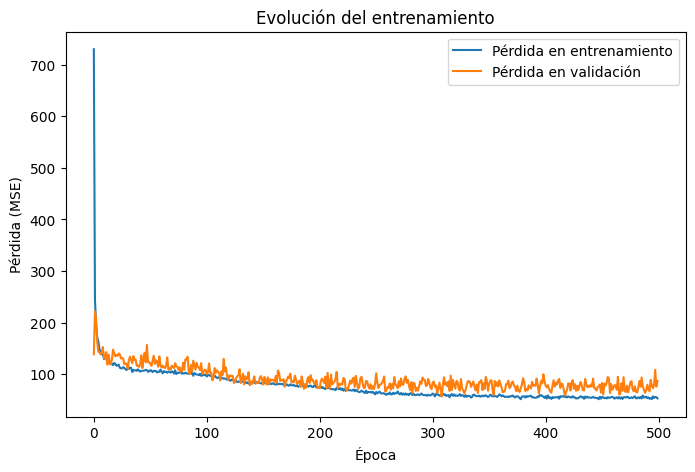

In [47]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # Salida de regresión
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,  # si quieres un split interno de validación
    epochs=500, #2000
    batch_size=32
)


# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

In [48]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {loss}, Test MAE: {mae}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113.5200 - mae: 8.6596 
Test MSE: 115.83537292480469, Test MAE: 8.713737487792969


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


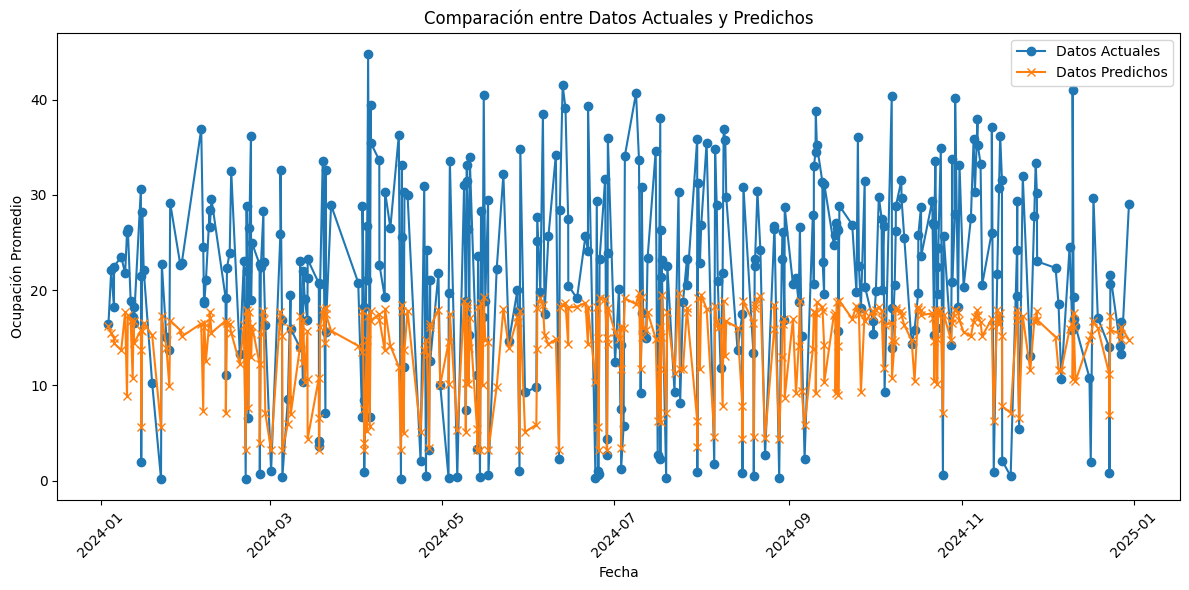

In [49]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': pd.to_datetime(fecha_test['dia'].astype(str)+ ' ' + fecha_test[ 'hora_cerrada'].astype(str)),
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
# Se filtra una línea específica
linea_especifica88 = 88
datos_filtrados88 = datos_combinados[datos_combinados['linea_codigo'] == linea_especifica2]

# Para la hora (24 horas)
datos_filtrados88['hora_sin'] = np.sin(2 * np.pi * datos_filtrados88['hora_cerrada'] / 24)
datos_filtrados88['hora_cos'] = np.cos(2 * np.pi * datos_filtrados88['hora_cerrada'] / 24)

# Para el mes (12 meses)
datos_filtrados88['mes_sin'] = np.sin(2 * np.pi * (datos_filtrados88['mes'] - 1) / 12)
datos_filtrados88['mes_cos'] = np.cos(2 * np.pi * (datos_filtrados88['mes'] - 1) / 12)

# Para el día de la semana (7 días)
datos_filtrados88['dia_semana_sin'] = np.sin(2 * np.pi * datos_filtrados88['dia_semana'] / 7)
datos_filtrados88['dia_semana_cos'] = np.cos(2 * np.pi * datos_filtrados88['dia_semana'] / 7)

# hacemos one hot en columna categorica
datos_filtrados88 = pd.get_dummies(datos_filtrados88, columns=['tipo_dia'], prefix='tipo_dia')

<ipython-input-50-be71c72a4d2f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados88['hora_sin'] = np.sin(2 * np.pi * datos_filtrados88['hora_cerrada'] / 24)
<ipython-input-50-be71c72a4d2f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados88['hora_cos'] = np.cos(2 * np.pi * datos_filtrados88['hora_cerrada'] / 24)
<ipython-input-50-be71c72a4d2f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [51]:
# Elegimos las columnas finales para X
feature_cols = [
    'hora_sin', 'hora_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'mes_sin', 'mes_cos',
    'precipitacion_1h'
]

# Incluir las columnas one-hot generadas
tipo_dia_cols = [col for col in datos_filtrados88.columns if col.startswith('tipo_dia_')]
feature_cols.extend(tipo_dia_cols)


# Definimos X e y
X = datos_filtrados88[feature_cols].copy()
y = datos_filtrados88['ocupacion_promedio'].values
fechas = datos_filtrados88[['dia', 'hora_cerrada']]  # Guardamos la fecha para poder graficar posteriormente

scaler = StandardScaler()

# Identificamos qué columnas en X son numéricas continuas y no están ya en [-1,1]
numeric_cols = ['precipitacion_1h']

# Ajustamos y transformamos
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1542.5430 - mae: 30.2235 - val_loss: 114.7930 - val_mae: 9.0692
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 241.6501 - mae: 12.3260 - val_loss: 106.2209 - val_mae: 8.5953
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 180.6688 - mae: 10.7431 - val_loss: 109.0859 - val_mae: 8.7651
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 146.1448 - mae: 9.6774 - val_loss: 116.6947 - val_mae: 9.1628
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 132.1449 - mae: 9.2676 - val_loss: 124.9563 - val_mae: 9.5516
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 132.0259 - mae: 9.2444 - val_loss: 109.7713 - val_mae: 8.8020
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 142.1501 - mae: 9.7234 - val_loss: 109.3157 - val_mae: 8.7776
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 125.3348 - mae: 8.9276 - val_loss: 119.9753 - val_mae: 9.3236
Epoch 9/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 

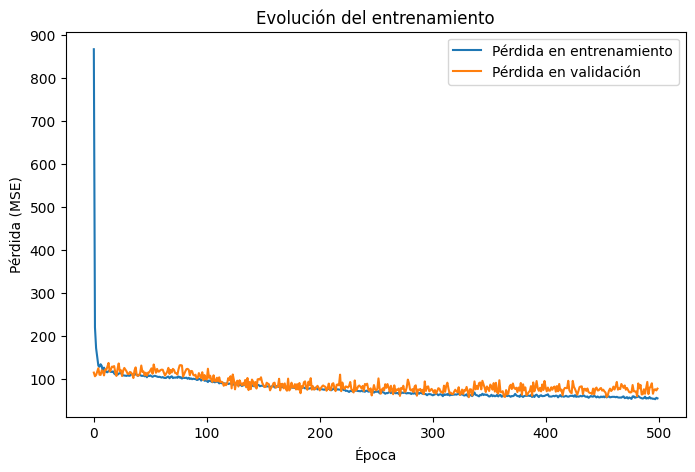

In [52]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # Salida de regresión
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,  # si quieres un split interno de validación
    epochs=500, #2000
    batch_size=32
)


# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

In [53]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {loss}, Test MAE: {mae}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.0250 - mae: 8.1265 
Test MSE: 105.62841796875, Test MAE: 8.188504219055176


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


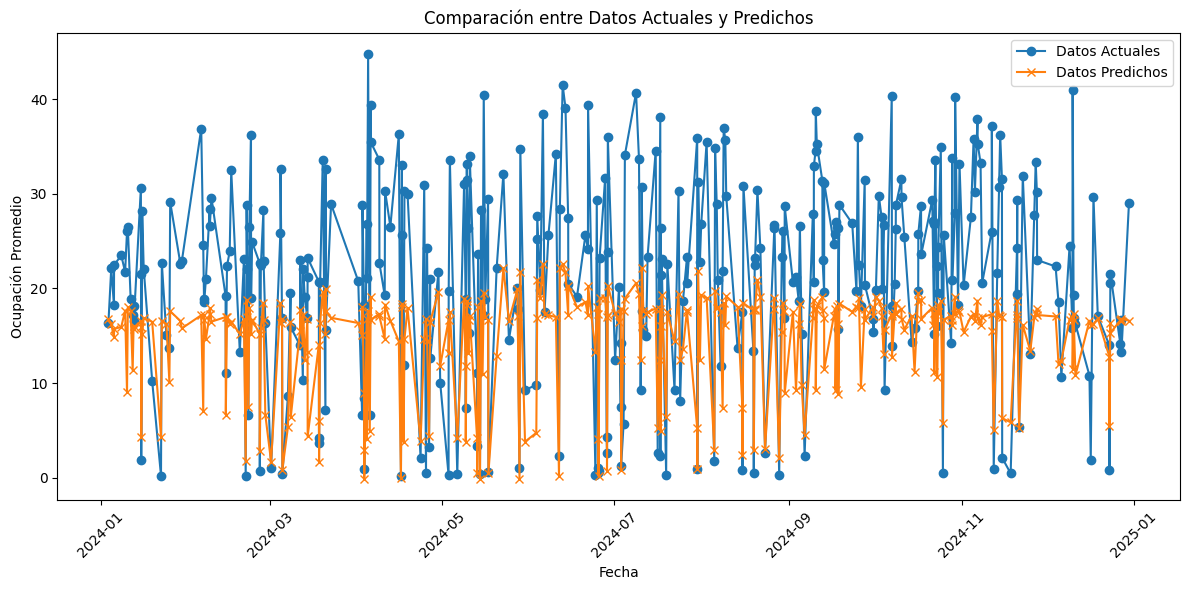

In [54]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': pd.to_datetime(fecha_test['dia'].astype(str)+ ' ' + fecha_test[ 'hora_cerrada'].astype(str)),
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Las líneas que corresponde cada código

| **Código de línea** | **Línea** |
|---------------|-------|
| 504           | 124   |
| 20            | 546   |
| 484           | L12   |
| 23            | 100   |
| 497           | G     |
| 2             | 404   |

In [55]:
#Se toman:
# Codigo linea 504 y 20 => las de mayor promerdio
# Codigo linea 484 y 23 => dos random
# Codigo linea 497 y 2 => las de mayor maximo de ocupación
lineas_especificas = [504, 20, 484, 23, 497, 2]
datos_filtrados_conjunto = datos_combinados[datos_combinados['linea_codigo'].isin(lineas_especificas)]

In [56]:
datos_filtrados_conjunto.head()

dia  hora_cerrada  linea_codigo tipo_dia  ocupacion_promedio  \
34 2024-01-02             0             2    HABIL            0.940865   
39 2024-01-02             0            20    HABIL            2.800000   
73 2024-01-02             0           497    HABIL            0.927198   
74 2024-01-02             1             2    HABIL            1.375000   
82 2024-01-02             1            20    HABIL            2.459016   

                       fecha  precipitacion_1h  mes  dia_semana  
34 2024-01-02 00:00:00-03:00               0.0    1           1  
39 2024-01-02 00:00:00-03:00               0.0    1           1  
73 2024-01-02 00:00:00-03:00               0.0    1           1  
74 2024-01-02 01:00:00-03:00               0.0    1           1  
82 2024-01-02 01:00:00-03:00               0.0    1           1

In [57]:
# Hacemos pivot. index = las columnas que identifican unívocamente un "momento" sin la línea,
# columns = linea_codigo, values = ocupacion_promedio.

df_wide = datos_filtrados_conjunto.pivot(
    index=['dia', 'hora_cerrada', 'tipo_dia', 'fecha', 'precipitacion_1h', 'mes', 'dia_semana'],
    columns='linea_codigo',
    values='ocupacion_promedio'
).reset_index()

In [58]:
#se renombran las columnas para que no queden solo los numeros de las lineas
new_cols = {}
for col in df_wide.columns:
    # omite las columnas del index
    if col not in ['dia','hora_cerrada','tipo_dia','fecha','precipitacion_1h','mes','dia_semana']:
        new_cols[col] = f'occup_linea{col}'

df_wide.rename(columns=new_cols, inplace=True)


In [59]:
df_wide.head()

linea_codigo        dia  hora_cerrada tipo_dia                     fecha  \
0            2024-01-02             0    HABIL 2024-01-02 00:00:00-03:00   
1            2024-01-02             1    HABIL 2024-01-02 01:00:00-03:00   
2            2024-01-02             2    HABIL 2024-01-02 02:00:00-03:00   
3            2024-01-02             3    HABIL 2024-01-02 03:00:00-03:00   
4            2024-01-02             4    HABIL 2024-01-02 04:00:00-03:00   

linea_codigo  precipitacion_1h  mes  dia_semana  occup_linea2  occup_linea20  \
0                          0.0    1           1      0.940865       2.800000   
1                          0.0    1           1      1.375000       2.459016   
2                          0.0    1           1      1.359776       2.400000   
3                          0.0    1           1      1.177419       1.015385   
4                          0.0    1           1      2.268996      14.415893   

linea_codigo  occup_linea23  occup_linea484  occup_linea497  occup_linea504  
0                       NaN             NaN        0.927198             NaN  
1                       NaN             NaN        3.116750             NaN  
2                       NaN             NaN        1.510807             NaN  
3                       NaN             NaN             NaN             NaN  
4                      24.0             NaN       11.151107             NaN

In [60]:
df_wide.head()

linea_codigo        dia  hora_cerrada tipo_dia                     fecha  \
0            2024-01-02             0    HABIL 2024-01-02 00:00:00-03:00   
1            2024-01-02             1    HABIL 2024-01-02 01:00:00-03:00   
2            2024-01-02             2    HABIL 2024-01-02 02:00:00-03:00   
3            2024-01-02             3    HABIL 2024-01-02 03:00:00-03:00   
4            2024-01-02             4    HABIL 2024-01-02 04:00:00-03:00   

linea_codigo  precipitacion_1h  mes  dia_semana  occup_linea2  occup_linea20  \
0                          0.0    1           1      0.940865       2.800000   
1                          0.0    1           1      1.375000       2.459016   
2                          0.0    1           1      1.359776       2.400000   
3                          0.0    1           1      1.177419       1.015385   
4                          0.0    1           1      2.268996      14.415893   

linea_codigo  occup_linea23  occup_linea484  occup_linea497  occup_linea504  
0                       NaN             NaN        0.927198             NaN  
1                       NaN             NaN        3.116750             NaN  
2                       NaN             NaN        1.510807             NaN  
3                       NaN             NaN             NaN             NaN  
4                      24.0             NaN       11.151107             NaN

In [61]:
# Para hora (24 horas)
df_wide['hora_sin'] = np.sin(2 * np.pi * df_wide['hora_cerrada'] / 24)
df_wide['hora_cos'] = np.cos(2 * np.pi * df_wide['hora_cerrada'] / 24)

# Para el día de la semana (7 días)
df_wide['dia_semana_sin'] = np.sin(2 * np.pi * df_wide['dia_semana'] / 7)
df_wide['dia_semana_cos'] = np.cos(2 * np.pi * df_wide['dia_semana'] / 7)

# Para el mes (12 meses)
# (restar 1 para que enero sea 0, diciembre 11)
df_wide['mes_sin'] = np.sin(2 * np.pi * (df_wide['mes'] - 1) / 12)
df_wide['mes_cos'] = np.cos(2 * np.pi * (df_wide['mes'] - 1) / 12)

df_wide = pd.get_dummies(df_wide, columns=['tipo_dia'], prefix='tipo_dia')

df_wide.fillna(0, inplace=True)

####Miro los datos por mes con lluevia y sin lluvia para saber que mes me convienen mas elegir como test, osea que sea mas parejo

In [62]:
# Crear una columna categórica de lluvia (0 = Sin lluvia, 1 = Con lluvia)
df_wide['lluvia'] = (df_wide['precipitacion_1h'] > 0).astype(int)

# Contar registros por mes y condición de lluvia
conteo_por_mes = df_wide.groupby(['mes', 'lluvia']).size().unstack(fill_value=0)

# Renombrar columnas
conteo_por_mes.columns = ['Sin lluvia', 'Con lluvia']
conteo_por_mes['Total'] = conteo_por_mes.sum(axis=1)  # Agregar columna total

print(conteo_por_mes)

     Sin lluvia  Con lluvia  Total
mes                               
1           633          56    689
2           618          78    696
3           576         167    743
4           508         208    716
5           573         146    719
6           603         117    720
7           693          51    744
8           586         158    744
9           641          79    720
10          684          60    744
11          609         110    719
12          616         116    732


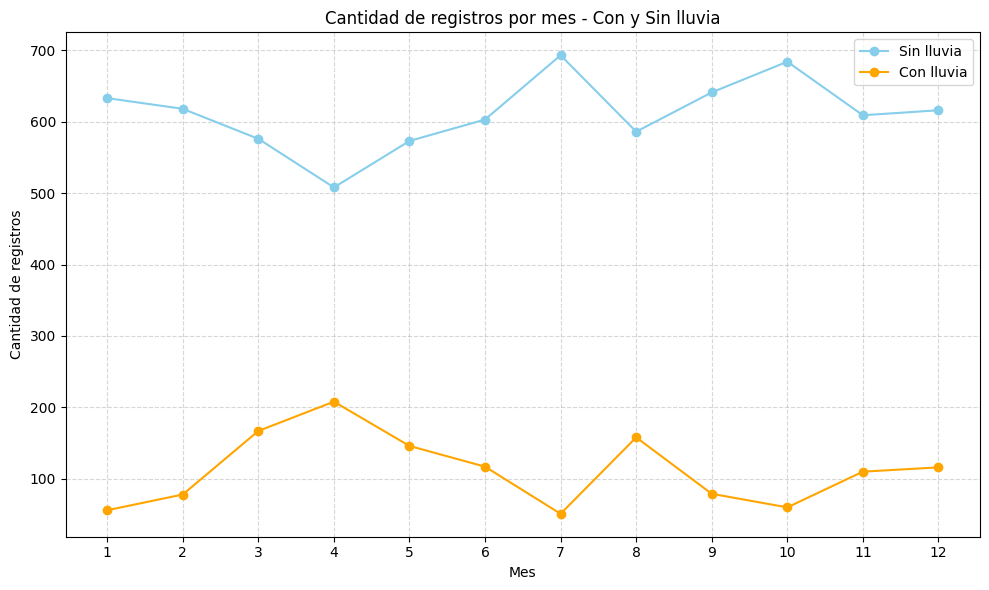

In [63]:
# Usamos el índice como eje X (meses)
meses = conteo_por_mes.index

plt.figure(figsize=(10, 6))
plt.plot(meses, conteo_por_mes['Sin lluvia'], marker='o', label='Sin lluvia', color='skyblue')
plt.plot(meses, conteo_por_mes['Con lluvia'], marker='o', label='Con lluvia', color='orange')

plt.title('Cantidad de registros por mes - Con y Sin lluvia')
plt.xlabel('Mes')
plt.ylabel('Cantidad de registros')
plt.xticks(meses)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


####Conlclución
**EL mes 4 es el mes con mas datos con lluvia, sindo este el mejor para elegir como dataset de test**

In [64]:
import re

# Buscamos todas las columnas que empiezan con "occup_linea"
target_cols = [c for c in df_wide.columns if c.startswith('occup_linea')]

# Armamos la lista de features.
# Excluimos las columnas que no aportan o que no hacen parte del input.

feature_cols = ['mes',
    'hora_sin', 'hora_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'mes_sin', 'mes_cos',
    'precipitacion_1h'
]
# Agregamos todas las one-hot generadas de tipo_dia
tipo_dia_cols = [c for c in df_wide.columns if c.startswith('tipo_dia_')]
feature_cols.extend(tipo_dia_cols)

# X e Y

# Separar los datos según el mes
df_train = df_wide[df_wide['mes'] != 4]  # Todos los meses excepto julio
df_test = df_wide[df_wide['mes'] == 4]   # Solo julio

X_train = df_train[feature_cols].copy()
y_train = df_train[target_cols].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test[target_cols].copy()


#x = df_wide[feature_cols].copy()   # shape (N, numero_features)
#y = df_wide[target_cols].copy()    # shape (N, 5) si hay 5 líneas
fechas = df_wide[['dia', 'hora_cerrada']]


In [65]:
print("--------------------------------------------------")
print("Cantidad de datos en train:", len(df_train))
print("Cantidad de datos en test:", len(df_test))
print("--------------------------------------------------")
# Verificar los meses en cada conjunto
print("Meses en train:", df_train['mes'].unique())
print("Meses en test:", df_test['mes'].unique())
print("--------------------------------------------------")
# Verificar cantidad de registros directamente
print("Total de datos para mes 4:", (df_wide['mes'] == 4).sum())


--------------------------------------------------
Cantidad de datos en train: 7970
Cantidad de datos en test: 716
--------------------------------------------------
Meses en train: [ 1  2  3  5  6  7  8  9 10 11 12]
Meses en test: [4]
--------------------------------------------------
Total de datos para mes 4: 716


In [66]:
df_wide.head()

dia  hora_cerrada                     fecha  precipitacion_1h  mes  \
0 2024-01-02             0 2024-01-02 00:00:00-03:00               0.0    1   
1 2024-01-02             1 2024-01-02 01:00:00-03:00               0.0    1   
2 2024-01-02             2 2024-01-02 02:00:00-03:00               0.0    1   
3 2024-01-02             3 2024-01-02 03:00:00-03:00               0.0    1   
4 2024-01-02             4 2024-01-02 04:00:00-03:00               0.0    1   

   dia_semana  occup_linea2  occup_linea20  occup_linea23  occup_linea484  \
0           1      0.940865       2.800000            0.0             0.0   
1           1      1.375000       2.459016            0.0             0.0   
2           1      1.359776       2.400000            0.0             0.0   
3           1      1.177419       1.015385            0.0             0.0   
4           1      2.268996      14.415893           24.0             0.0   

   ...  dia_semana_sin  dia_semana_cos  mes_sin  mes_cos  \
0  ...        0.781831         0.62349      0.0      1.0   
1  ...        0.781831         0.62349      0.0      1.0   
2  ...        0.781831         0.62349      0.0      1.0   
3  ...        0.781831         0.62349      0.0      1.0   
4  ...        0.781831         0.62349      0.0      1.0   

   tipo_dia_FERIADO LABORABLE  tipo_dia_FERIADO NO LABORABLE  tipo_dia_HABIL  \
0                       False                          False            True   
1                       False                          False            True   
2                       False                          False            True   
3                       False                          False            True   
4                       False                          False            True   

   tipo_dia_TIPO DOMINGO  tipo_dia_TIPO SABADO  lluvia  
0                  False                 False       0  
1                  False                 False       0  
2                  False                 False       0  
3                  False                 False       0  
4                  False                 False       0  

[5 rows x 24 columns]

####Verifico la separación de un mes para trining

In [67]:
X_train.columns

Index(['mes', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos',
       'mes_sin', 'mes_cos', 'precipitacion_1h', 'tipo_dia_FERIADO LABORABLE',
       'tipo_dia_FERIADO NO LABORABLE', 'tipo_dia_HABIL',
       'tipo_dia_TIPO DOMINGO', 'tipo_dia_TIPO SABADO'],
      dtype='object')

In [68]:
X_test

mes  hora_sin      hora_cos  dia_semana_sin  dia_semana_cos  mes_sin  \
2128    4  0.000000  1.000000e+00        0.000000         1.00000      1.0   
2129    4  0.258819  9.659258e-01        0.000000         1.00000      1.0   
2130    4  0.500000  8.660254e-01        0.000000         1.00000      1.0   
2131    4  0.707107  7.071068e-01        0.000000         1.00000      1.0   
2132    4  0.866025  5.000000e-01        0.000000         1.00000      1.0   
...   ...       ...           ...             ...             ...      ...   
2839    4 -0.866025 -5.000000e-01        0.781831         0.62349      1.0   
2840    4 -0.965926 -2.588190e-01        0.781831         0.62349      1.0   
2841    4 -1.000000 -1.836970e-16        0.781831         0.62349      1.0   
2842    4 -0.965926  2.588190e-01        0.781831         0.62349      1.0   
2843    4 -0.866025  5.000000e-01        0.781831         0.62349      1.0   

           mes_cos  precipitacion_1h  tipo_dia_FERIADO LABORABLE  \
2128  6.123234e-17          0.000000                       False   
2129  6.123234e-17          0.000000                       False   
2130  6.123234e-17          0.201524                       False   
2131  6.123234e-17          1.413333                       False   
2132  6.123234e-17          1.197048                       False   
...            ...               ...                         ...   
2839  6.123234e-17          0.000000                       False   
2840  6.123234e-17          0.000000                       False   
2841  6.123234e-17          0.000000                       False   
2842  6.123234e-17          0.275048                       False   
2843  6.123234e-17          0.832286                       False   

      tipo_dia_FERIADO NO LABORABLE  tipo_dia_HABIL  tipo_dia_TIPO DOMINGO  \
2128                          False            True                  False   
2129                          False            True                  False   
2130                          False            True                  False   
2131                          False            True                  False   
2132                          False            True                  False   
...                             ...             ...                    ...   
2839                          False            True                  False   
2840                          False            True                  False   
2841                          False            True                  False   
2842                          False            True                  False   
2843                          False            True                  False   

      tipo_dia_TIPO SABADO  
2128                 False  
2129                 False  
2130                 False  
2131                 False  
2132                 False  
...                    ...  
2839                 False  
2840                 False  
2841                 False  
2842                 False  
2843                 False  

[716 rows x 13 columns]

In [69]:
# Verificar los meses en el conjunto de test
print("Meses en X_test:", X_test['mes'].unique())

# Verificar los meses en el conjunto de train
print("Meses en X_train:", X_train['mes'].unique())

# Filas por mes
print("\nDistribución de meses en X_test:")
print(X_test['mes'].value_counts())

Meses en X_test: [4]
Meses en X_train: [ 1  2  3  5  6  7  8  9 10 11 12]

Distribución de meses en X_test:
mes
4    716
Name: count, dtype: int64


In [70]:

scaler = StandardScaler()
num_cols_to_scale = ['precipitacion_1h']

# Ajustar el scaler con X_train
scaler.fit(X_train[num_cols_to_scale])
# Transformar
X_train[num_cols_to_scale] = scaler.transform(X_train[num_cols_to_scale])
X_test[num_cols_to_scale]  = scaler.transform(X_test[num_cols_to_scale])

In [71]:
num_features = X_train.shape[1]      # cantidad de columnas en X
num_lines = y_train.shape[1]         # aquí 6 (número de líneas)

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(y_train.shape[1])
])

model.compile(
    optimizer='adam',
    loss='mse',   # MSE de las 6 salidas
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32
)


Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 193.4275 - mae: 10.1828 - val_loss: 77.2369 - val_mae: 6.9731
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 49.2236 - mae: 5.2000 - val_loss: 58.0487 - val_mae: 5.9771
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 44.3289 - mae: 4.9246 - val_loss: 57.5127 - val_mae: 5.9977
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 42.3431 - mae: 4.7659 - val_loss: 44.9328 - val_mae: 5.1080
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.9388 - mae: 4.5258 - val_loss: 40.9583 - val_mae: 4.8199
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35.6627 - mae: 4.3147 - val_loss: 38.5749 - val_mae: 4.5845
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34.6618 - mae: 4.1885 - val_loss: 39.9642 - val_mae: 4.7319
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33.3237 - mae: 4.1126 - val_loss: 36.6951 - val_mae: 4.3803
Epoch 9/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1

In [72]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MSE (promedio para las 6 líneas): {loss}")
print(f"Test MAE (promedio para las 6 líneas): {mae}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.7466 - mae: 2.4471
Test MSE (promedio para las 6 líneas): 14.605430603027344
Test MAE (promedio para las 6 líneas): 2.4154043197631836


In [73]:
preds = model.predict(X_test)

for i, linea in enumerate(target_cols):
    y_real = y_test.iloc[:, i]        # DataFrame → Serie de la columna i
    y_pred = preds[:, i]             # array NumPy

    mse_line = np.mean((y_real - y_pred) ** 2)
    mae_line = np.mean(np.abs(y_real - y_pred))
    print(f"Línea {linea}: MSE={mse_line:.2f}, MAE={mae_line:.2f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Línea occup_linea2: MSE=11.45, MAE=2.42
Línea occup_linea20: MSE=24.66, MAE=3.41
Línea occup_linea23: MSE=9.66, MAE=2.31
Línea occup_linea484: MSE=9.39, MAE=1.73
Línea occup_linea497: MSE=16.72, MAE=3.05
Línea occup_linea504: MSE=15.75, MAE=1.56


In [74]:
print(len(fecha_test))  # Debería ser igual a len(X_test)
print(len(X_test))
print(len(y_test))

354
716
716


In [75]:
# Supongamos que fecha_test es un DataFrame con columnas 'dia' y 'hora_cerrada'
#Agregue esto para ver si corrigue error
fecha_test = fecha_test.iloc[:len(y_test)].copy()  # Ajustar tamaño si es necesario

fecha_test['dia'] = pd.to_datetime(fecha_test['dia'], format="%Y-%m-%d")

# Convertimos la hora (0..23) a un Timedelta y la sumamos a la fecha
fecha_test['fecha_completa'] = fecha_test['dia'] + pd.to_timedelta(fecha_test['hora_cerrada'], unit='h')

# Ahora 'fecha_completa' es una sola columna con el datetime (YYYY-MM-DD HH:00:00)


In [76]:
len(datos_combinados)

861433

In [77]:
len(datos_filtrados)

1766

In [78]:
X_test.shape

(716, 13)

In [79]:
datos_combinados.shape

(861433, 9)

In [80]:
datos_filtrados.shape

(1766, 15)

In [81]:
len(X_test)

716

###Estudio los datos de test

In [82]:
X_test.head()

mes  hora_sin  hora_cos  dia_semana_sin  dia_semana_cos  mes_sin  \
2128    4  0.000000  1.000000             0.0             1.0      1.0   
2129    4  0.258819  0.965926             0.0             1.0      1.0   
2130    4  0.500000  0.866025             0.0             1.0      1.0   
2131    4  0.707107  0.707107             0.0             1.0      1.0   
2132    4  0.866025  0.500000             0.0             1.0      1.0   

           mes_cos  precipitacion_1h  tipo_dia_FERIADO LABORABLE  \
2128  6.123234e-17         -0.120599                       False   
2129  6.123234e-17         -0.120599                       False   
2130  6.123234e-17         -0.001878                       False   
2131  6.123234e-17          0.712018                       False   
2132  6.123234e-17          0.584601                       False   

      tipo_dia_FERIADO NO LABORABLE  tipo_dia_HABIL  tipo_dia_TIPO DOMINGO  \
2128                          False            True                  False   
2129                          False            True                  False   
2130                          False            True                  False   
2131                          False            True                  False   
2132                          False            True                  False   

      tipo_dia_TIPO SABADO  
2128                 False  
2129                 False  
2130                 False  
2131                 False  
2132                 False

In [83]:
y_test.head()

occup_linea2  occup_linea20  occup_linea23  occup_linea484  \
2128      1.515625       5.800683            0.0             0.0   
2129      2.562500       5.545833            0.0             0.0   
2130      1.382812       1.383333            0.0             0.0   
2131      2.103448       0.578125            0.0             0.0   
2132      6.361962      16.945224           32.0             0.0   

      occup_linea497  occup_linea504  
2128        9.011905             0.0  
2129        8.164557             0.0  
2130        1.476190             0.0  
2131        0.000000             0.0  
2132        8.617205             0.0

In [84]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MSE (promedio para las 5 líneas): {loss}")
print(f"Test MAE (promedio para las 5 líneas): {mae}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.7466 - mae: 2.4471
Test MSE (promedio para las 5 líneas): 14.605430603027344
Test MAE (promedio para las 5 líneas): 2.4154043197631836


In [85]:
# Filtrar los datos de test según la precipitación
X_test_lluvia = X_test[X_test['precipitacion_1h'] > 0]
y_test_lluvia = y_test.loc[X_test_lluvia.index]

X_test_sin_lluvia = X_test[X_test['precipitacion_1h'] <= 0]
y_test_sin_lluvia = y_test.loc[X_test_sin_lluvia.index]

# Obtener predicciones del modelo
if not X_test_lluvia.empty:
    y_pred_lluvia = model.predict(X_test_lluvia)
    resultados_lluvia = pd.DataFrame(y_test_lluvia, columns=y_test.columns)
    resultados_lluvia['prediccion'] = list(y_pred_lluvia)
else:
    print("No hay datos con lluvia en el conjunto de x_test.")

if not X_test_sin_lluvia.empty:
    y_pred_sin_lluvia = model.predict(X_test_sin_lluvia)
    resultados_sin_lluvia = pd.DataFrame(y_test_sin_lluvia, columns=y_test.columns)
    resultados_sin_lluvia['prediccion'] = list(y_pred_sin_lluvia)
else:
    print("No hay datos sin lluvia en el conjunto de X_test_sin_lluvia.")

# Convertir a DataFrame para facilitar el análisis
resultados_lluvia = pd.DataFrame(y_test_lluvia, columns=y_test.columns)
resultados_lluvia['prediccion'] = y_pred_lluvia.tolist()

resultados_sin_lluvia = pd.DataFrame(y_test_sin_lluvia, columns=y_test.columns)
resultados_sin_lluvia['prediccion'] = y_pred_sin_lluvia.tolist()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [86]:
# Cantidad de datos test con lluvia
len(X_test_lluvia)

112

In [87]:
X_test_sin_lluvia

mes      hora_sin      hora_cos  dia_semana_sin  dia_semana_cos  \
2128    4  0.000000e+00  1.000000e+00        0.000000         1.00000   
2129    4  2.588190e-01  9.659258e-01        0.000000         1.00000   
2130    4  5.000000e-01  8.660254e-01        0.000000         1.00000   
2140    4  1.224647e-16 -1.000000e+00        0.000000         1.00000   
2141    4 -2.588190e-01 -9.659258e-01        0.000000         1.00000   
...   ...           ...           ...             ...             ...   
2837    4 -5.000000e-01 -8.660254e-01        0.781831         0.62349   
2838    4 -7.071068e-01 -7.071068e-01        0.781831         0.62349   
2839    4 -8.660254e-01 -5.000000e-01        0.781831         0.62349   
2840    4 -9.659258e-01 -2.588190e-01        0.781831         0.62349   
2841    4 -1.000000e+00 -1.836970e-16        0.781831         0.62349   

      mes_sin       mes_cos  precipitacion_1h  tipo_dia_FERIADO LABORABLE  \
2128      1.0  6.123234e-17         -0.120599                       False   
2129      1.0  6.123234e-17         -0.120599                       False   
2130      1.0  6.123234e-17         -0.001878                       False   
2140      1.0  6.123234e-17         -0.099222                       False   
2141      1.0  6.123234e-17         -0.120599                       False   
...       ...           ...               ...                         ...   
2837      1.0  6.123234e-17         -0.120599                       False   
2838      1.0  6.123234e-17         -0.120599                       False   
2839      1.0  6.123234e-17         -0.120599                       False   
2840      1.0  6.123234e-17         -0.120599                       False   
2841      1.0  6.123234e-17         -0.120599                       False   

      tipo_dia_FERIADO NO LABORABLE  tipo_dia_HABIL  tipo_dia_TIPO DOMINGO  \
2128                          False            True                  False   
2129                          False            True                  False   
2130                          False            True                  False   
2140                          False            True                  False   
2141                          False            True                  False   
...                             ...             ...                    ...   
2837                          False            True                  False   
2838                          False            True                  False   
2839                          False            True                  False   
2840                          False            True                  False   
2841                          False            True                  False   

      tipo_dia_TIPO SABADO  
2128                 False  
2129                 False  
2130                 False  
2140                 False  
2141                 False  
...                    ...  
2837                 False  
2838                 False  
2839                 False  
2840                 False  
2841                 False  

[604 rows x 13 columns]

In [88]:
# Cantidad de datos test sin lluvia
len(resultados_sin_lluvia)

604

In [89]:
resultados_sin_lluvia

occup_linea2  occup_linea20  occup_linea23  occup_linea484  \
2128      1.515625       5.800683       0.000000        0.000000   
2129      2.562500       5.545833       0.000000        0.000000   
2130      1.382812       1.383333       0.000000        0.000000   
2140     22.740878      26.851612      21.653468        2.555556   
2141     17.087090      28.311817      25.348526        2.631579   
...            ...            ...            ...             ...   
2837     18.429295      17.650683      16.052281        0.000000   
2838     18.187337      28.125807      20.168583        0.000000   
2839     20.485757      30.687792      25.427366        0.000000   
2840     17.600000      36.771900      23.717298        0.000000   
2841     14.195433      18.042857      16.669229        0.000000   

      occup_linea497  occup_linea504  \
2128        9.011905        0.000000   
2129        8.164557        0.000000   
2130        1.476190        0.000000   
2140       26.630514        0.000000   
2141       25.908255        0.000000   
...              ...             ...   
2837       23.982306        0.000000   
2838       27.670560       22.651163   
2839       33.581914       15.372093   
2840       36.836520       27.651163   
2841       20.257836       20.058140   

                                             prediccion  
2128  [2.6646945476531982, 4.843423843383789, 1.1978...  
2129  [2.1893765926361084, 3.92934513092041, 0.50391...  
2130  [1.8183274269104004, 2.41741943359375, 0.28724...  
2140  [17.504636764526367, 27.45411491394043, 18.821...  
2141  [17.185508728027344, 29.25571632385254, 21.429...  
...                                                 ...  
2837  [16.22977066040039, 28.597652435302734, 21.981...  
2838  [17.316295623779297, 29.018001556396484, 22.87...  
2839  [18.173994064331055, 31.532569885253906, 24.75...  
2840  [18.044801712036133, 31.201026916503906, 23.28...  
2841  [12.65397834777832, 24.44424057006836, 18.9397...  

[604 rows x 7 columns]

###Evaluamos como se comporto el modelo para los casos en test con lluvia vs sin lluvia

In [90]:
def evaluar_modelo(y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    return mae, mse

# Días de lluvia
mae_lluvia, mse_lluvia = evaluar_modelo(y_test_lluvia, y_pred_lluvia)

# Días sin lluvia
mae_sin_lluvia, mse_sin_lluvia = evaluar_modelo(y_test_sin_lluvia, y_pred_sin_lluvia)

# Mostrar resultados
print("Métricas para días con lluvia:")
print(f"  MAE: {mae_lluvia:.2f}, MSE: {mse_lluvia:.2f}")

print("\nMétricas para días sin lluvia:")
print(f"  MAE: {mae_sin_lluvia:.2f}, MSE: {mse_sin_lluvia:.2f}")

Métricas para días con lluvia:
  MAE: 2.42, MSE: 13.87

Métricas para días sin lluvia:
  MAE: 2.42, MSE: 14.74


In [91]:
# Convertir predicciones en DataFrames con los mismos nombres de columnas que y_test
y_pred_lluvia_df = pd.DataFrame(y_pred_lluvia, columns=y_test.columns, index=y_test_lluvia.index)
y_pred_sin_lluvia_df = pd.DataFrame(y_pred_sin_lluvia, columns=y_test.columns, index=y_test_sin_lluvia.index)

# Crear diccionario para almacenar métricas
metricas_por_linea = {}

# Iterar sobre cada línea de ómnibus
for linea in y_test.columns:
    # Evaluar para días de lluvia
    mae_lluvia = mean_absolute_error(y_test_lluvia[linea], y_pred_lluvia_df[linea])
    mse_lluvia = mean_squared_error(y_test_lluvia[linea], y_pred_lluvia_df[linea])

    # Evaluar para días sin lluvia
    mae_sin_lluvia = mean_absolute_error(y_test_sin_lluvia[linea], y_pred_sin_lluvia_df[linea])
    mse_sin_lluvia = mean_squared_error(y_test_sin_lluvia[linea], y_pred_sin_lluvia_df[linea])

    # Guardar resultados en el diccionario
    metricas_por_linea[linea] = {
        "lluvia": {"MAE": mae_lluvia, "MSE": mse_lluvia},
        "sin_lluvia": {"MAE": mae_sin_lluvia, "MSE": mse_sin_lluvia},
    }

# Convertir a DataFrame
df_metricas = pd.DataFrame.from_dict({(i, j): metricas_por_linea[i][j]
                                      for i in metricas_por_linea.keys()
                                      for j in metricas_por_linea[i].keys()},
                                     orient='index')

# Mostrar resultados
print(df_metricas)


                                MAE        MSE
occup_linea2   lluvia      2.011714   7.631460
               sin_lluvia  2.493780  12.159431
occup_linea20  lluvia      3.806783  28.969122
               sin_lluvia  3.340275  23.860472
occup_linea23  lluvia      2.343358  10.690869
               sin_lluvia  2.307631   9.471198
occup_linea484 lluvia      1.833645   9.443674
               sin_lluvia  1.716480   9.376571
occup_linea497 lluvia      3.103165  15.449020
               sin_lluvia  3.039761  16.958468
occup_linea504 lluvia      1.399525  11.063954
               sin_lluvia  1.593427  16.619475


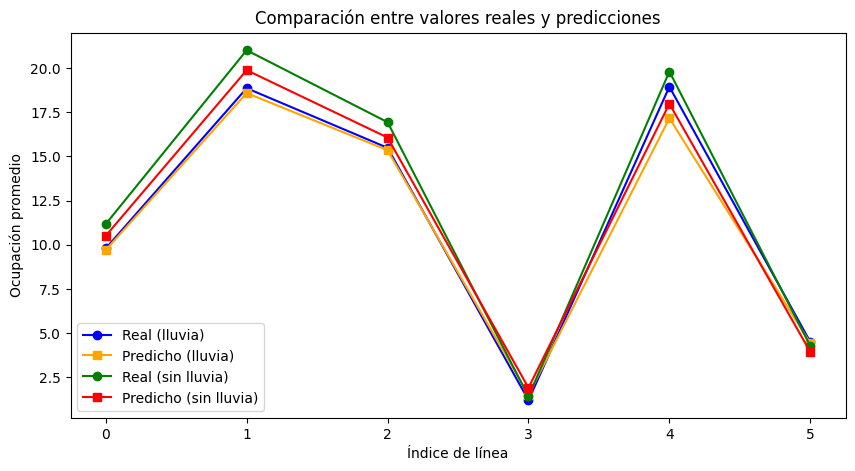

In [92]:
# Calcular estadísticas para lluvia
mean_real_lluvia = y_test_lluvia.mean(axis=0)
std_real_lluvia = y_test_lluvia.std(axis=0)
mean_pred_lluvia = y_pred_lluvia.mean(axis=0)
std_pred_lluvia = y_pred_lluvia.std(axis=0)

# Calcular estadísticas para sin lluvia
mean_real_sin_lluvia = y_test_sin_lluvia.mean(axis=0)
std_real_sin_lluvia = y_test_sin_lluvia.std(axis=0)
mean_pred_sin_lluvia = y_pred_sin_lluvia.mean(axis=0)
std_pred_sin_lluvia = y_pred_sin_lluvia.std(axis=0)

# Índices de líneas (puedes usar nombres si prefieres)
lineas = range(len(mean_real_lluvia))

plt.figure(figsize=(10, 5))

# Graficar medias con bandas de desviación estándar
plt.plot(lineas, mean_real_lluvia, label="Real (lluvia)", color="blue", marker="o")


plt.plot(lineas, mean_pred_lluvia, label="Predicho (lluvia)", color="orange", marker="s")


plt.plot(lineas, mean_real_sin_lluvia, label="Real (sin lluvia)", color="green", marker="o")


plt.plot(lineas, mean_pred_sin_lluvia, label="Predicho (sin lluvia)", color="red", marker="s")


plt.xlabel("Índice de línea")
plt.ylabel("Ocupación promedio")
plt.title("Comparación entre valores reales y predicciones")
plt.legend()
plt.show()

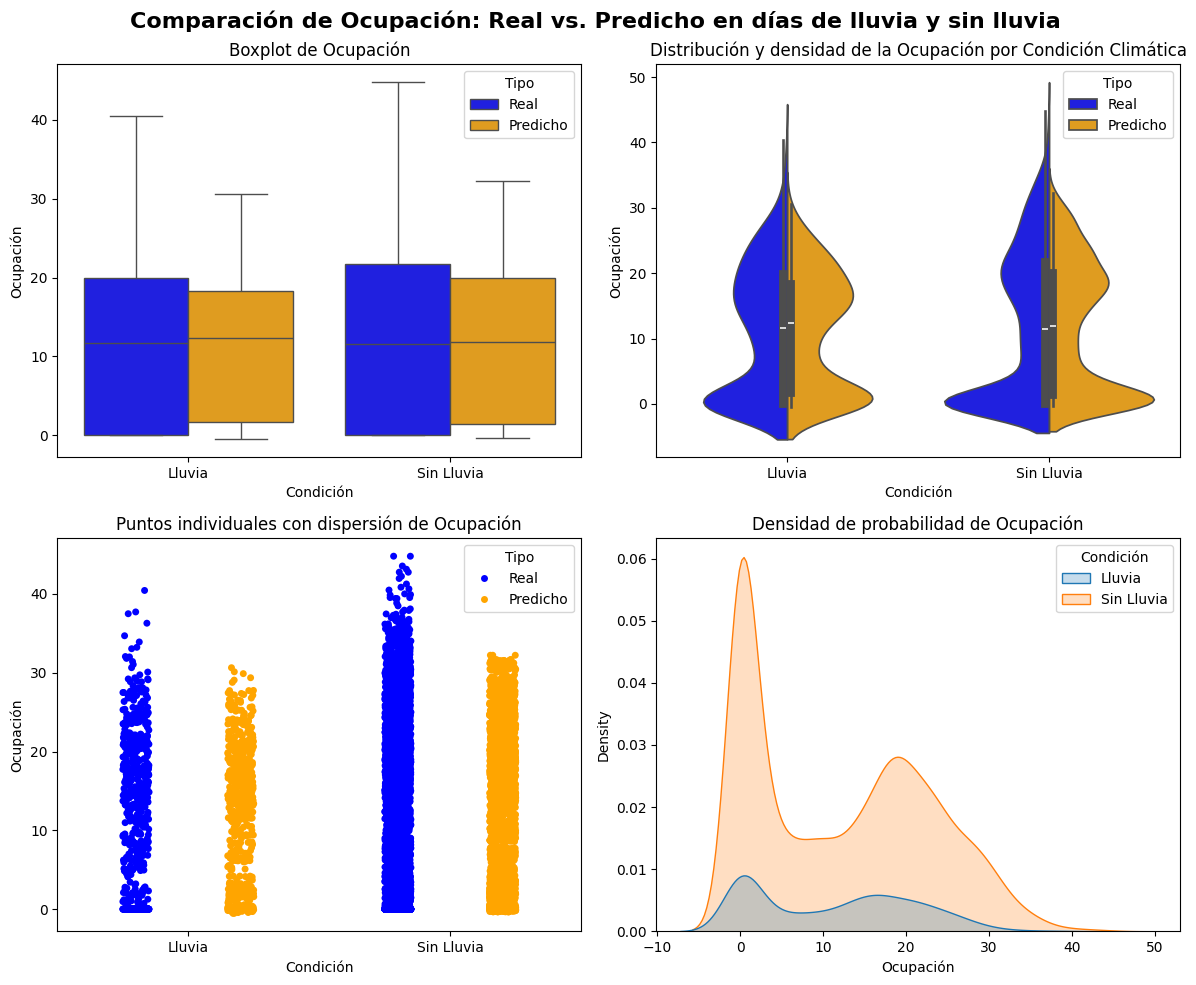

In [93]:
# Crear DataFrame con los valores reales y predichos
df_boxplot_sin_bayesian = pd.DataFrame({
    "Ocupación": np.concatenate([y_test_lluvia.values.flatten(), y_test_sin_lluvia.values.flatten(),
                                 y_pred_lluvia.flatten(), y_pred_sin_lluvia.flatten()]),
    "Condición": ["Lluvia"] * len(y_test_lluvia.values.flatten()) + ["Sin Lluvia"] * len(y_test_sin_lluvia.values.flatten()) +
                 ["Lluvia"] * len(y_pred_lluvia.flatten()) + ["Sin Lluvia"] * len(y_pred_sin_lluvia.flatten()),
    "Tipo": ["Real"] * (len(y_test_lluvia.values.flatten()) + len(y_test_sin_lluvia.values.flatten())) +
            ["Predicho"] * (len(y_pred_lluvia.flatten()) + len(y_pred_sin_lluvia.flatten()))
})

# Crear figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparación de Ocupación: Real vs. Predicho en días de lluvia y sin lluvia", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Boxplot
sns.boxplot(x="Condición", y="Ocupación", hue="Tipo", data=df_boxplot_sin_bayesian, ax=axes[0, 0], palette={"Real": "blue", "Predicho": "orange"})
axes[0, 0].set_title("Boxplot de Ocupación")

# Violin Plot
sns.violinplot(x="Condición", y="Ocupación", hue="Tipo", data=df_boxplot_sin_bayesian, ax=axes[0, 1], split=True, palette={"Real": "blue", "Predicho": "orange"})
axes[0, 1].set_title("Distribución y densidad de la Ocupación por Condición Climática")

# Strip Plot
sns.stripplot(x="Condición", y="Ocupación", hue="Tipo", data=df_boxplot_sin_bayesian, ax=axes[1, 0], dodge=True, jitter=True, palette={"Real": "blue", "Predicho": "orange"})
axes[1, 0].set_title("Puntos individuales con dispersión de Ocupación")


# KDE Plot
sns.kdeplot(data=df_boxplot_sin_bayesian, x="Ocupación", hue="Condición", fill=True, ax=axes[1, 1])
axes[1, 1].set_title("Densidad de probabilidad de Ocupación")

# Ajustar diseño
plt.tight_layout()
plt.show()


###Probambos cambiar el modelo para usar Bayesian Optimization para la optimización de los hiperparamentros

In [94]:
############################ PRUEBA CON 3 CAPAS #########################################
# Separar un conjunto de validación dentro de train (sin incluir el mes 4)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Definir función de optimización
def modelo_bayesiano(neurons_1, neurons_2, dropout_1, dropout_2, learning_rate):
    neurons_1 = int(neurons_1)
    neurons_2 = int(neurons_2)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(neurons_1, activation='relu'),
        layers.Dropout(dropout_1),
        layers.Dense(neurons_2, activation='relu'),
        layers.Dropout(dropout_2),
        layers.Dense(y_train.shape[1])  # Salida sin activación
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Agregar Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val),
              epochs=500, batch_size=32, verbose=0, callbacks=[early_stopping])

    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    return -loss  # Negativo para minimizar

# Definir los rangos de búsqueda para cada hiperparámetro
param_bounds = {
    'neurons_1': (32, 128),
    'neurons_2': (16, 64),
    'dropout_1': (0.1, 0.5),
    'dropout_2': (0.1, 0.5),
    'learning_rate': (1e-4, 1e-2)
}

# Aplicar optimización bayesiana
optimizer = BayesianOptimization(f=modelo_bayesiano, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=15, n_iter=20)

# Obtener los mejores hiperparámetros
best_params = optimizer.max['params']
best_params['neurons_1'] = int(best_params['neurons_1'])
best_params['neurons_2'] = int(best_params['neurons_2'])

# Entrenar el modelo final con los mejores hiperparámetros
final_model = models.Sequential([
    layers.Dense(best_params['neurons_1'], activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(best_params['dropout_1']),
    layers.Dense(best_params['neurons_2'], activation='relu'),
    layers.Dropout(best_params['dropout_2']),
    layers.Dense(y_train.shape[1])
])

final_optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=final_optimizer, loss='mse', metrics=['mae'])

# Entrenar modelo final con Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
final_model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val),
                epochs=500, batch_size=32, callbacks=[early_stopping])


|   iter    |  target   | dropout_1 | dropout_2 | learni... | neurons_1 | neurons_2 |
-------------------------------------------------------------------------------------
| 1         | -17.64    | 0.2498    | 0.4803    | 0.007347  | 89.47     | 23.49     |
| 2         | -13.95    | 0.1624    | 0.1232    | 0.008675  | 89.71     | 49.99     |
| 3         | -17.5     | 0.1082    | 0.488     | 0.008341  | 52.38     | 24.73     |
| 4         | -15.26    | 0.1734    | 0.2217    | 0.005295  | 73.47     | 29.98     |
| 5         | -16.24    | 0.3447    | 0.1558    | 0.002992  | 67.17     | 37.89     |
| 6         | -16.2     | 0.4141    | 0.1799    | 0.005191  | 88.87     | 18.23     |
| 7         | -14.08    | 0.343     | 0.1682    | 0.000744  | 123.1     | 62.35     |
| 8         | -15.19    | 0.4234    | 0.2218    | 0.001067  | 97.69     | 37.13     |
| 9         | -15.5     | 0.1488    | 0.2981    | 0.0004404 | 119.3     | 28.42     |
| 10        | -16.31    | 0.365     | 0.2247    | 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 114.8489 - mae: 7.6743 - val_loss: 40.1176 - val_mae: 4.4783
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 41.7929 - mae: 4.6813 - val_loss: 32.1697 - val_mae: 4.0245
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35.0390 - mae: 4.2605 - val_loss: 27.2754 - val_mae: 3.7179
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32.0670 - mae: 4.0502 - val_loss: 24.4526 - val_mae: 3.4208
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 28.1375 - mae: 3.7536 - val_loss: 21.2407 - val_mae: 3.1695
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 26.1341 - mae: 3.6163 - val_loss: 19.8055 - val_mae: 3.0886
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 24.5229 - mae: 3.4970 - val_loss: 19.2094 - val_mae: 2.9410
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.0622 - mae: 3.3628 - val_loss: 17.8420 - val_mae: 2.8789
Epoch 9/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s

In [ ]:
############################### NUEVA CON 4 CAPAS #########################################
# 4 capas como en el paper y como veniamos trabajado
# Separar un conjunto de validación dentro de train (sin incluir el mes 4)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Definir función de optimización
def modelo_bayesiano(neurons_1, neurons_2, neurons_3, dropout_1, dropout_2, dropout_3, learning_rate):
    neurons_1 = int(neurons_1)
    neurons_2 = int(neurons_2)
    neurons_3 = int(neurons_3)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(neurons_1, activation='relu'),
        layers.Dropout(dropout_1),
        layers.Dense(neurons_2, activation='relu'),
        layers.Dropout(dropout_2),
        layers.Dense(neurons_3, activation='relu'),
        layers.Dropout(dropout_3),
        layers.Dense(y_train.shape[1])  # Salida sin activación
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Agregar Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val),
              epochs=500, batch_size=32, verbose=0, callbacks=[early_stopping])

    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    return -loss  # Negativo para minimizar

# Definir los rangos de búsqueda para cada hiperparámetro
param_bounds = {
    'neurons_1': (8, 160),
    'neurons_2': (8, 160),
    'neurons_3': (8, 120),
    'dropout_1': (0.1, 0.5),
    'dropout_2': (0.1, 0.5),
    'dropout_3': (0.1, 0.5),
    'learning_rate': (1e-4, 1e-2)
}

# Aplicar optimización bayesiana
optimizer = BayesianOptimization(f=modelo_bayesiano, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=15, n_iter=20)

# Obtener los mejores hiperparámetros
best_params = optimizer.max['params']
best_params['neurons_1'] = int(best_params['neurons_1'])
best_params['neurons_2'] = int(best_params['neurons_2'])
best_params['neurons_3'] = int(best_params['neurons_3'])

# Entrenar el modelo final con los mejores hiperparámetros
final_model = models.Sequential([
    layers.Dense(best_params['neurons_1'], activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(best_params['dropout_1']),
    layers.Dense(best_params['neurons_2'], activation='relu'),
    layers.Dropout(best_params['dropout_2']),
    layers.Dense(best_params['neurons_3'], activation='relu'),
    layers.Dropout(best_params['dropout_3']),
    layers.Dense(y_train.shape[1])
])

final_optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=final_optimizer, loss='mse', metrics=['mae'])

# Entrenar modelo final con Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
final_model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val),
                epochs=500, batch_size=32, callbacks=[early_stopping])

# Guardar el modelo
ruta_modelo = '/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/modelo_final.keras'
final_model.save(ruta_modelo)
print(f'Modelo guardado en: {ruta_modelo}')

|   iter    |  target   | dropout_1 | dropout_2 | dropout_3 | learni... | neurons_1 | neurons_2 | neurons_3 |
-------------------------------------------------------------------------------------------------------------
| 1         | -22.13    | 0.2498    | 0.4803    | 0.3928    | 0.006027  | 31.71     | 31.71     | 14.51     |
| 2         | -17.33    | 0.4465    | 0.3404    | 0.3832    | 0.0003038 | 155.4     | 134.5     | 31.78     |
| 3         | -14.21    | 0.1727    | 0.1734    | 0.2217    | 0.005295  | 73.66     | 52.27     | 76.53     |
| 4         | -14.81    | 0.1558    | 0.2169    | 0.2465    | 0.004615  | 127.3     | 38.35     | 65.59     |
| 5         | -31.48    | 0.337     | 0.1186    | 0.343     | 0.001788  | 17.89     | 152.2     | 116.2     |
| 6         | -16.52    | 0.4234    | 0.2218    | 0.1391    | 0.006874  | 74.9      | 26.55     | 63.46     |
| 7         | -15.58    | 0.1138    | 0.4637    | 0.2035    | 0.006659  | 55.38     | 87.05     | 69.23     |
| 8       

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 103.9923 - mae: 7.2962 - val_loss: 36.9465 - val_mae: 4.4267
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.3322 - mae: 4.5317 - val_loss: 29.1188 - val_mae: 3.7899
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32.9957 - mae: 4.1213 - val_loss: 23.2256 - val_mae: 3.2878
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27.7140 - mae: 3.6939 - val_loss: 18.4892 - val_mae: 2.9032
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.9476 - mae: 3.3933 - val_loss: 20.0913 - val_mae: 2.9868
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.9335 - mae: 3.2670 - val_loss: 17.4469 - val_mae: 2.7666
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.2360 - mae: 3.1639 - val_loss: 17.0002 - val_mae: 2.6913
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.4696 - mae: 3.0992 - val_loss: 15.9484 - val_mae: 2.5958
Epoch 9/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s

In [ ]:
best_params

{'dropout_1': np.float64(0.1353970008207678),
 'dropout_2': np.float64(0.1783931449676581),
 'dropout_3': np.float64(0.11809091556421523),
 'learning_rate': np.float64(0.003320770274556317),
 'neurons_1': 67,
 'neurons_2': 49,
 'neurons_3': 100}

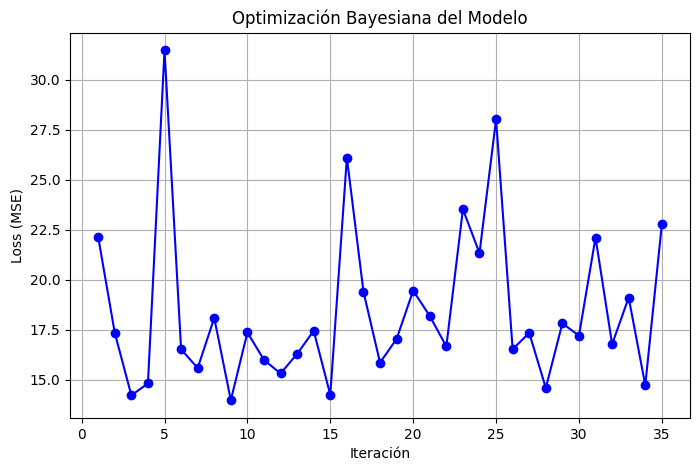

In [ ]:
# Extraer datos de la optimización
iterations = list(range(1, len(optimizer.res) + 1))
losses = [-res['target'] for res in optimizer.res]  # Recordar que minimizamos -loss

# Graficar la función objetivo a lo largo de las iteraciones
plt.figure(figsize=(8, 5))
plt.plot(iterations, losses, marker='o', linestyle='-', color='b')
plt.xlabel("Iteración")
plt.ylabel("Loss (MSE)")
plt.title("Optimización Bayesiana del Modelo")
plt.grid()
plt.show()


In [ ]:
loss, mae = final_model.evaluate(X_test, y_test)
print(f"Test MSE (promedio para las 5 líneas): {loss}")
print(f"Test MAE (promedio para las 5 líneas): {mae}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.7486 - mae: 2.3731 
Test MSE (promedio para las 5 líneas): 13.731075286865234
Test MAE (promedio para las 5 líneas): 2.3718554973602295


In [ ]:
# Filtrar los datos de test según la precipitación
X_test_lluvia = X_test[X_test['precipitacion_1h'] > 0]
y_test_lluvia = y_test.loc[X_test_lluvia.index]

X_test_sin_lluvia = X_test[X_test['precipitacion_1h'] <= 0]
y_test_sin_lluvia = y_test.loc[X_test_sin_lluvia.index]

# Obtener predicciones del final_model
if not X_test_lluvia.empty:
    y_pred_lluvia = final_model.predict(X_test_lluvia)
    resultados_lluvia = pd.DataFrame(y_test_lluvia, columns=y_test.columns)
    resultados_lluvia['prediccion'] = list(y_pred_lluvia)
else:
    print("No hay datos con lluvia en el conjunto de x_test.")

if not X_test_sin_lluvia.empty:
    y_pred_sin_lluvia = final_model.predict(X_test_sin_lluvia)
    resultados_sin_lluvia = pd.DataFrame(y_test_sin_lluvia, columns=y_test.columns)
    resultados_sin_lluvia['prediccion'] = list(y_pred_sin_lluvia)
else:
    print("No hay datos sin lluvia en el conjunto de X_test_sin_lluvia.")

# Convertir a DataFrame para facilitar el análisis
resultados_lluvia = pd.DataFrame(y_test_lluvia, columns=y_test.columns)
resultados_lluvia['prediccion'] = y_pred_lluvia.tolist()

resultados_sin_lluvia = pd.DataFrame(y_test_sin_lluvia, columns=y_test.columns)
resultados_sin_lluvia['prediccion'] = y_pred_sin_lluvia.tolist()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# Cantidad de datos test sin lluvia
len(X_test_sin_lluvia)

604

In [ ]:
# Cantidad de datos test con lluvia
len(X_test_lluvia)

112

###Evaluamos como se comporto el modelo con los hiperparamentros ajustado automaticamente, para los casos en test con lluvia vs sin lluvia

In [ ]:
def evaluar_modelo(y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    return mae, mse

# Días de lluvia
mae_lluvia, mse_lluvia = evaluar_modelo(y_test_lluvia, y_pred_lluvia)

# Días sin lluvia
mae_sin_lluvia, mse_sin_lluvia = evaluar_modelo(y_test_sin_lluvia, y_pred_sin_lluvia)

# Mostrar resultados
print("Métricas para días con lluvia:")
print(f"  MAE: {mae_lluvia:.2f}, MSE: {mse_lluvia:.2f}")

print("\nMétricas para días sin lluvia:")
print(f"  MAE: {mae_sin_lluvia:.2f}, MSE: {mse_sin_lluvia:.2f}")

Métricas para días con lluvia:
  MAE: 2.55, MSE: 14.81

Métricas para días sin lluvia:
  MAE: 2.34, MSE: 13.53


In [ ]:
# Convertir predicciones en DataFrames con los mismos nombres de columnas que y_test
y_pred_lluvia_df = pd.DataFrame(y_pred_lluvia, columns=y_test.columns, index=y_test_lluvia.index)
y_pred_sin_lluvia_df = pd.DataFrame(y_pred_sin_lluvia, columns=y_test.columns, index=y_test_sin_lluvia.index)

# Crear diccionario para almacenar métricas
metricas_por_linea = {}

# Iterar sobre cada línea de ómnibus
for linea in y_test.columns:
    # Evaluar para días de lluvia
    mae_lluvia = mean_absolute_error(y_test_lluvia[linea], y_pred_lluvia_df[linea])
    mse_lluvia = mean_squared_error(y_test_lluvia[linea], y_pred_lluvia_df[linea])

    # Evaluar para días sin lluvia
    mae_sin_lluvia = mean_absolute_error(y_test_sin_lluvia[linea], y_pred_sin_lluvia_df[linea])
    mse_sin_lluvia = mean_squared_error(y_test_sin_lluvia[linea], y_pred_sin_lluvia_df[linea])

    # Guardar resultados en el diccionario
    metricas_por_linea[linea] = {
        "lluvia": {"MAE": mae_lluvia, "MSE": mse_lluvia},
        "sin_lluvia": {"MAE": mae_sin_lluvia, "MSE": mse_sin_lluvia},
    }

# Convertir a DataFrame
df_metricas = pd.DataFrame.from_dict({(i, j): metricas_por_linea[i][j]
                                      for i in metricas_por_linea.keys()
                                      for j in metricas_por_linea[i].keys()},
                                     orient='index')

# Mostrar resultados
print(df_metricas)

                                MAE        MSE
occup_linea2   lluvia      2.160107   7.810888
               sin_lluvia  2.478005  11.524640
occup_linea20  lluvia      3.571242  24.677058
               sin_lluvia  3.132432  21.416481
occup_linea23  lluvia      2.410034  11.636422
               sin_lluvia  2.171470   8.129660
occup_linea484 lluvia      1.957258   9.648430
               sin_lluvia  1.806443   9.533985
occup_linea497 lluvia      3.074660  14.074117
               sin_lluvia  2.856753  14.665848
occup_linea504 lluvia      2.135531  21.024332
               sin_lluvia  1.586191  15.913363


#Evaluamos distintas formas de visualizar en test para elegir la que mejor se visualiza

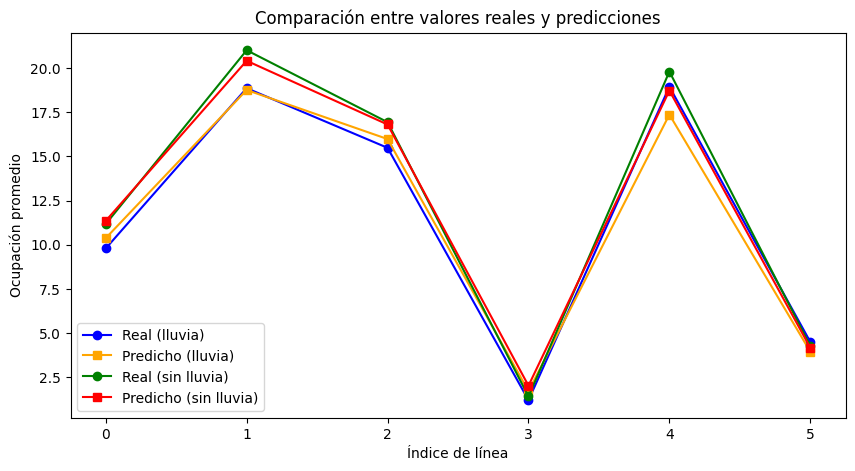

In [ ]:
# Calcular estadísticas para lluvia
mean_real_lluvia = y_test_lluvia.mean(axis=0)
std_real_lluvia = y_test_lluvia.std(axis=0)
mean_pred_lluvia = y_pred_lluvia.mean(axis=0)
std_pred_lluvia = y_pred_lluvia.std(axis=0)

# Calcular estadísticas para sin lluvia
mean_real_sin_lluvia = y_test_sin_lluvia.mean(axis=0)
std_real_sin_lluvia = y_test_sin_lluvia.std(axis=0)
mean_pred_sin_lluvia = y_pred_sin_lluvia.mean(axis=0)
std_pred_sin_lluvia = y_pred_sin_lluvia.std(axis=0)

# Índices de líneas (puedes usar nombres si prefieres)
lineas = range(len(mean_real_lluvia))

plt.figure(figsize=(10, 5))

# Graficar medias con bandas de desviación estándar
plt.plot(lineas, mean_real_lluvia, label="Real (lluvia)", color="blue", marker="o")
plt.plot(lineas, mean_pred_lluvia, label="Predicho (lluvia)", color="orange", marker="s")
plt.plot(lineas, mean_real_sin_lluvia, label="Real (sin lluvia)", color="green", marker="o")
plt.plot(lineas, mean_pred_sin_lluvia, label="Predicho (sin lluvia)", color="red", marker="s")

plt.xlabel("Índice de línea")
plt.ylabel("Ocupación promedio")
plt.title("Comparación entre valores reales y predicciones")
plt.legend()
plt.show()

###Boxplot de la ocupación los días de lluvia vs los días sin lluvia

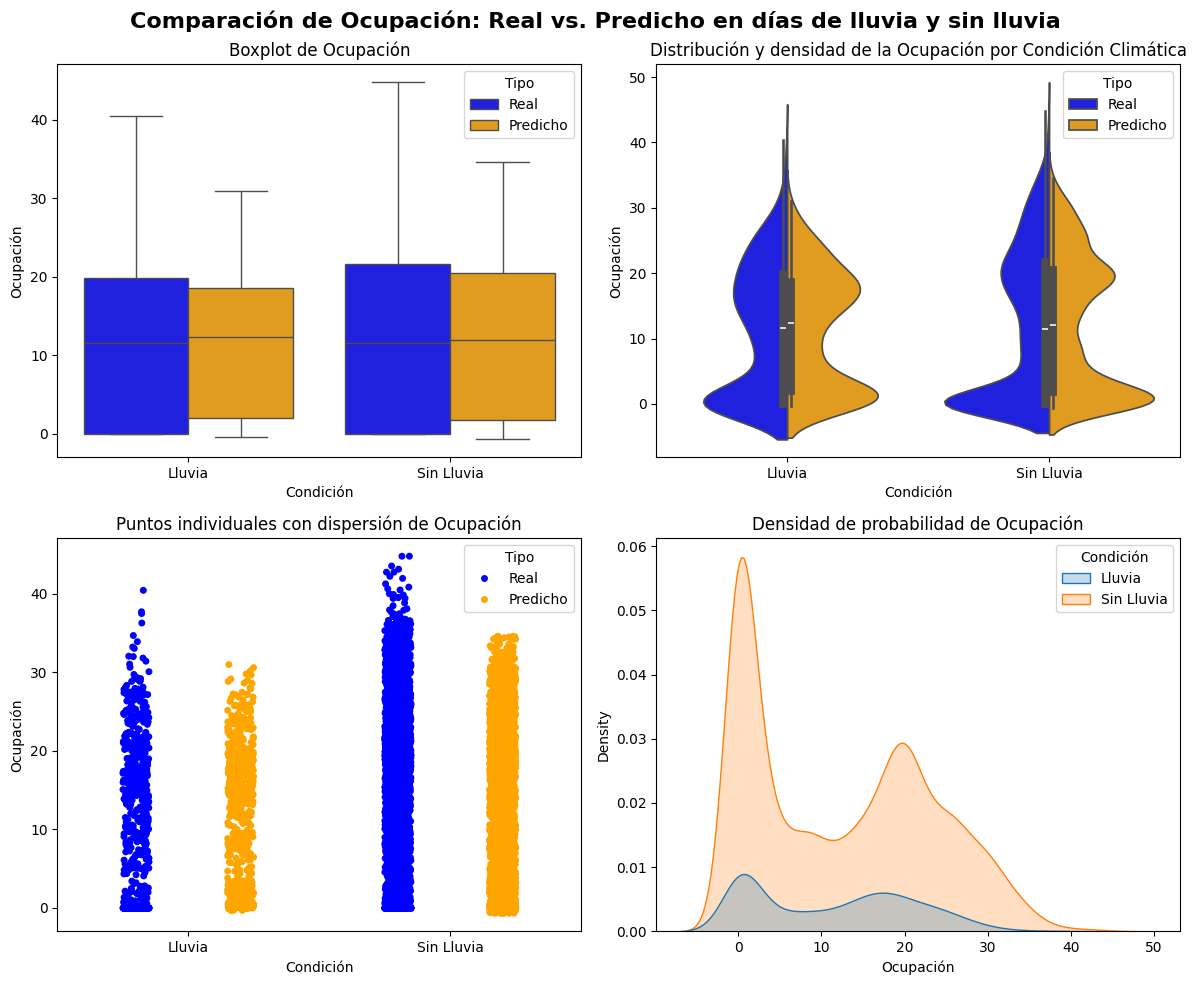

In [ ]:
# Crear DataFrame con los valores reales y predichos
df_boxplot = pd.DataFrame({
    "Ocupación": np.concatenate([y_test_lluvia.values.flatten(), y_test_sin_lluvia.values.flatten(),
                                 y_pred_lluvia.flatten(), y_pred_sin_lluvia.flatten()]),
    "Condición": ["Lluvia"] * len(y_test_lluvia.values.flatten()) + ["Sin Lluvia"] * len(y_test_sin_lluvia.values.flatten()) +
                 ["Lluvia"] * len(y_pred_lluvia.flatten()) + ["Sin Lluvia"] * len(y_pred_sin_lluvia.flatten()),
    "Tipo": ["Real"] * (len(y_test_lluvia.values.flatten()) + len(y_test_sin_lluvia.values.flatten())) +
            ["Predicho"] * (len(y_pred_lluvia.flatten()) + len(y_pred_sin_lluvia.flatten()))
})

# Crear figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparación de Ocupación: Real vs. Predicho en días de lluvia y sin lluvia", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Boxplot
sns.boxplot(x="Condición", y="Ocupación", hue="Tipo", data=df_boxplot, ax=axes[0, 0], palette={"Real": "blue", "Predicho": "orange"})
axes[0, 0].set_title("Boxplot de Ocupación")

# Violin Plot
sns.violinplot(x="Condición", y="Ocupación", hue="Tipo", data=df_boxplot, ax=axes[0, 1], split=True, palette={"Real": "blue", "Predicho": "orange"})
axes[0, 1].set_title("Distribución y densidad de la Ocupación por Condición Climática")

# Strip Plot
sns.stripplot(x="Condición", y="Ocupación", hue="Tipo", data=df_boxplot, ax=axes[1, 0], dodge=True, jitter=True, palette={"Real": "blue", "Predicho": "orange"})
axes[1, 0].set_title("Puntos individuales con dispersión de Ocupación")


# KDE Plot
sns.kdeplot(data=df_boxplot, x="Ocupación", hue="Condición", fill=True, ax=axes[1, 1])
axes[1, 1].set_title("Densidad de probabilidad de Ocupación")

# Ajustar diseño
plt.tight_layout()
plt.show()


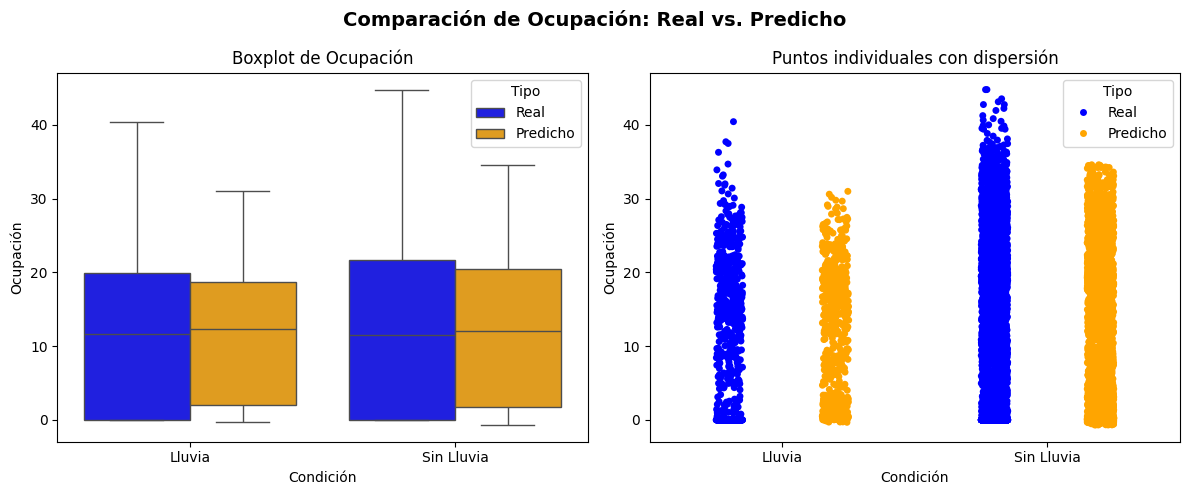

In [ ]:
# Me quedo con estas dos gráficas para el trabajo
# Crear DataFrame con los valores reales y predichos
df_boxplot_sin_bayesian = pd.DataFrame({
    "Ocupación": np.concatenate([y_test_lluvia.values.flatten(), y_test_sin_lluvia.values.flatten(),
                                 y_pred_lluvia.flatten(), y_pred_sin_lluvia.flatten()]),
    "Condición": ["Lluvia"] * len(y_test_lluvia.values.flatten()) + ["Sin Lluvia"] * len(y_test_sin_lluvia.values.flatten()) +
                 ["Lluvia"] * len(y_pred_lluvia.flatten()) + ["Sin Lluvia"] * len(y_pred_sin_lluvia.flatten()),
    "Tipo": ["Real"] * (len(y_test_lluvia.values.flatten()) + len(y_test_sin_lluvia.values.flatten())) +
            ["Predicho"] * (len(y_pred_lluvia.flatten()) + len(y_pred_sin_lluvia.flatten()))
})

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Comparación de Ocupación: Real vs. Predicho", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Boxplot
sns.boxplot(x="Condición", y="Ocupación", hue="Tipo", data=df_boxplot_sin_bayesian, ax=axes[0], palette={"Real": "blue", "Predicho": "orange"})
axes[0].set_title("Boxplot de Ocupación")

# Strip Plot
sns.stripplot(x="Condición", y="Ocupación", hue="Tipo", data=df_boxplot_sin_bayesian, ax=axes[1], dodge=True, jitter=True, palette={"Real": "blue", "Predicho": "orange"})
axes[1].set_title("Puntos individuales con dispersión")

# Ajustar diseño
plt.tight_layout()
plt.show()

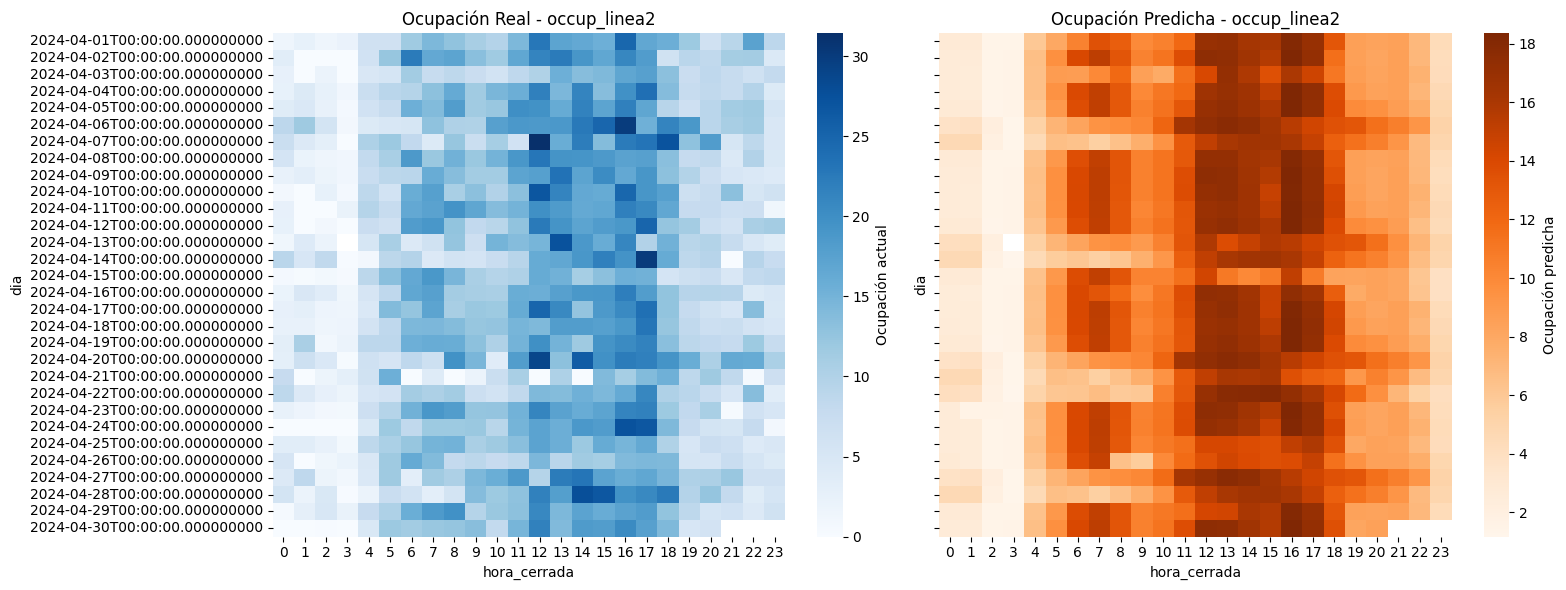

In [ ]:
# Elegimos una línea para graficar (por ejemplo, la primera)
line_idx = 0
line_name = target_cols[line_idx]

# Valores reales y predichos
y_real = y_test.iloc[:, line_idx].values
y_pred = preds[:, line_idx]

# Unimos día y hora con las predicciones
plot_df = df_test[['dia', 'hora_cerrada']].copy()
plot_df['actual'] = y_real
plot_df['predicted'] = y_pred

# Agrupamos por día y hora (promediando)
grouped = plot_df.groupby(['dia', 'hora_cerrada']).mean().reset_index()

# Pivotamos para armar mapas de calor
pivot_actual = grouped.pivot(index='dia', columns='hora_cerrada', values='actual')
pivot_pred = grouped.pivot(index='dia', columns='hora_cerrada', values='predicted')

# Graficamos
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.heatmap(pivot_actual, ax=axes[0], cmap='Blues', cbar_kws={'label': 'Ocupación actual'})
axes[0].set_title(f'Ocupación Real - {line_name}')

sns.heatmap(pivot_pred, ax=axes[1], cmap='Oranges', cbar_kws={'label': 'Ocupación predicha'})
axes[1].set_title(f'Ocupación Predicha - {line_name}')

plt.tight_layout()
plt.show()


<ipython-input-111-6cfb58bb8e4d>:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


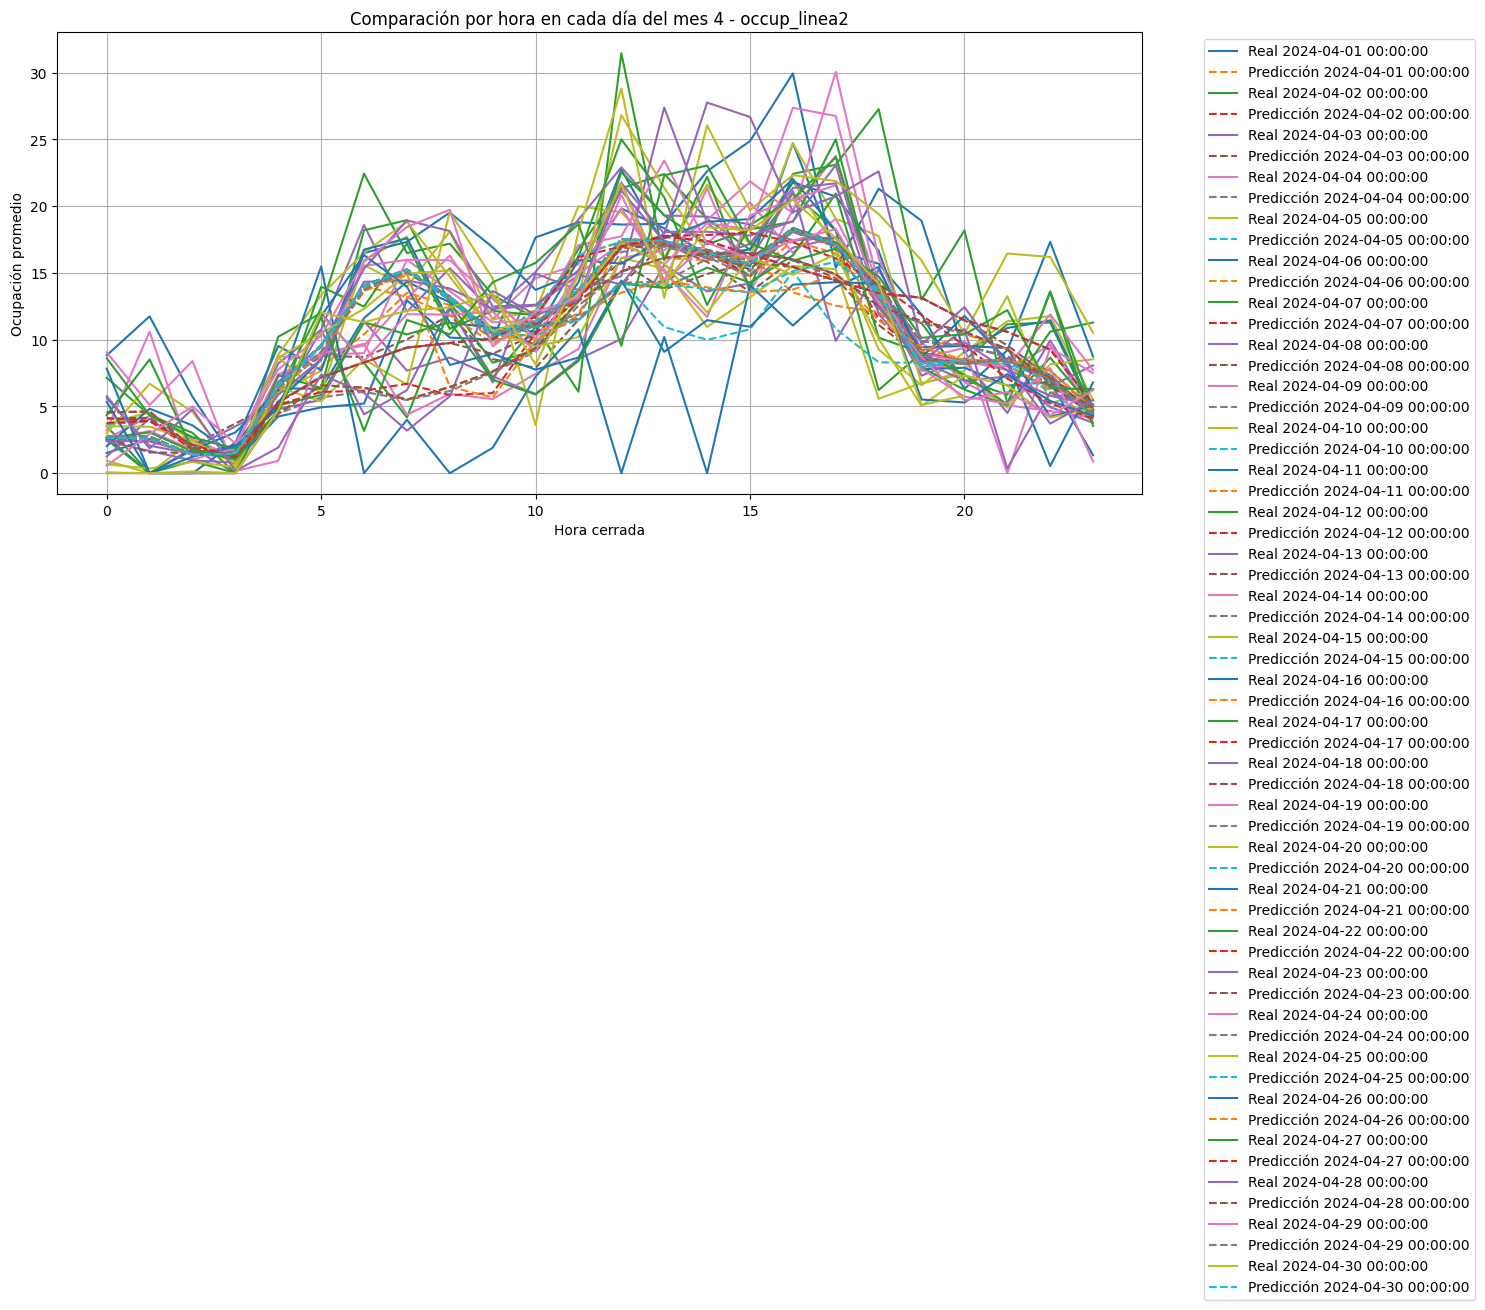

In [ ]:
# Filtramos la línea que querés visualizar (por ejemplo, la primera)
line_idx = 0
line_name = target_cols[line_idx]

# Obtenemos datos reales y predichos
y_real = y_test.iloc[:, line_idx].values
y_pred = preds[:, line_idx]

# Armamos un DataFrame con día, hora, real y predicho
plot_df = df_test[['dia', 'hora_cerrada']].copy()
plot_df['actual'] = y_real
plot_df['predicted'] = y_pred

# Ordenamos para graficar
plot_df.sort_values(['dia', 'hora_cerrada'], inplace=True)

# Graficamos líneas por cada día
dias_unicos = plot_df['dia'].unique()

plt.figure(figsize=(14, 6))

for dia in dias_unicos:
    datos_dia = plot_df[plot_df['dia'] == dia]
    plt.plot(datos_dia['hora_cerrada'], datos_dia['actual'], label=f'Real {dia}', linestyle='-')
    plt.plot(datos_dia['hora_cerrada'], datos_dia['predicted'], label=f'Predicción {dia}', linestyle='--')

plt.xlabel('Hora cerrada')
plt.ylabel('Ocupación promedio')
plt.title(f'Comparación por hora en cada día del mes 4 - {line_name}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# Corrijo la fecha para test asi poder graficarlo
df_wide['hora_cerrada_str'] = df_wide['hora_cerrada'].astype(int).astype(str).str.zfill(2) + ':00'

# Crear fecha_completa
df_wide['fecha_completa'] = pd.to_datetime(df_wide['dia'].astype(str) + ' ' + df_wide['hora_cerrada_str'])

df_test = df_wide[df_wide['mes'] == 4]
fecha_test = df_test[['fecha_completa']].reset_index(drop=True)


In [ ]:
fecha_test.head()

fecha_completa
0 2024-04-01 00:00:00
1 2024-04-01 01:00:00
2 2024-04-01 02:00:00
3 2024-04-01 03:00:00
4 2024-04-01 04:00:00

In [ ]:
resultados = pd.DataFrame()

for i, linea in enumerate(target_cols):
    y_real = y_test.iloc[:, i].values
    y_pred = preds[:, i]

    tmp = pd.DataFrame({
        'fecha': fecha_test['fecha_completa'].values,
        'real': y_real,
        'pred': y_pred,
        'linea': linea
    })

    # Extraemos día y hora
    tmp['dia'] = tmp['fecha'].dt.day
    tmp['hora'] = tmp['fecha'].dt.hour

    resultados = pd.concat([resultados, tmp], ignore_index=True)

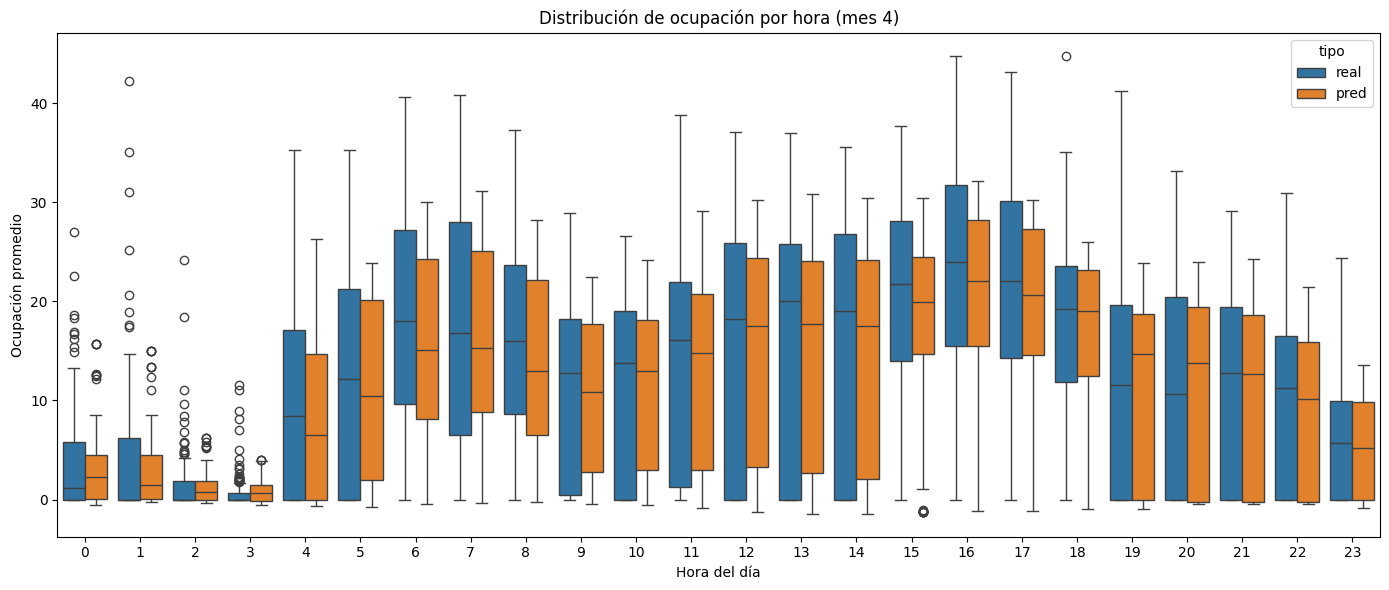

In [ ]:
df_melt = resultados.melt(id_vars=['hora', 'dia'], value_vars=['real', 'pred'],
                          var_name='tipo', value_name='ocupación')

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_melt, x='hora', y='ocupación', hue='tipo')
plt.title('Distribución de ocupación por hora (mes 4)')
plt.xlabel('Hora del día')
plt.ylabel('Ocupación promedio')
plt.tight_layout()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


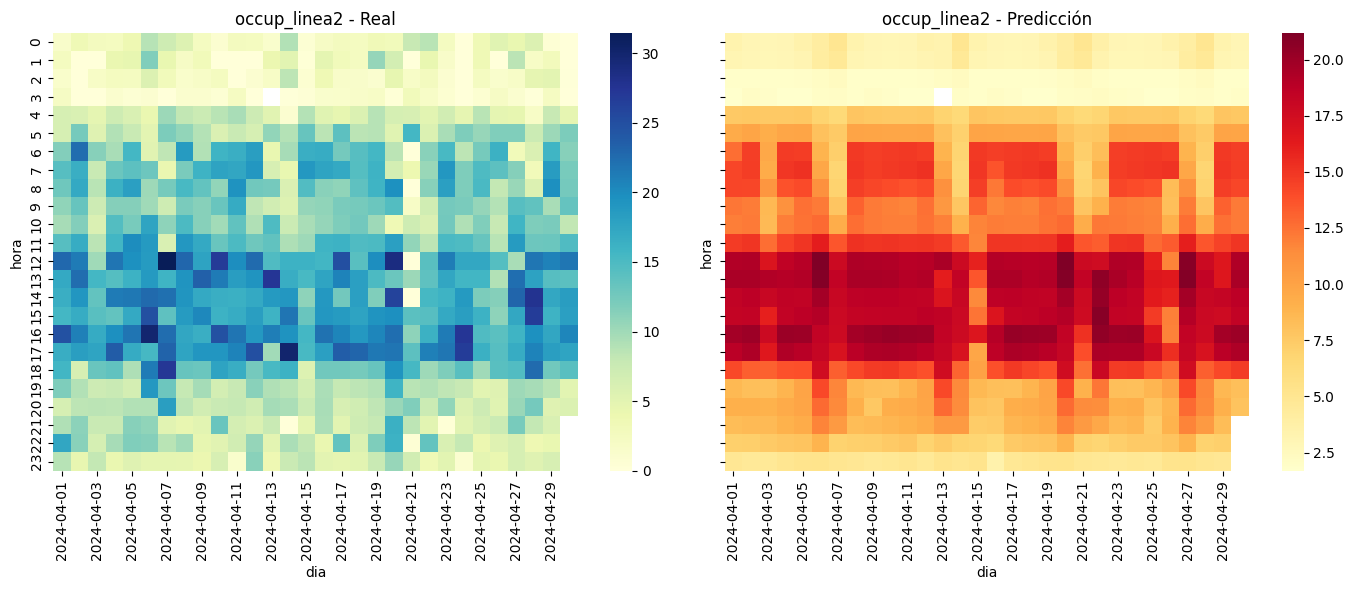

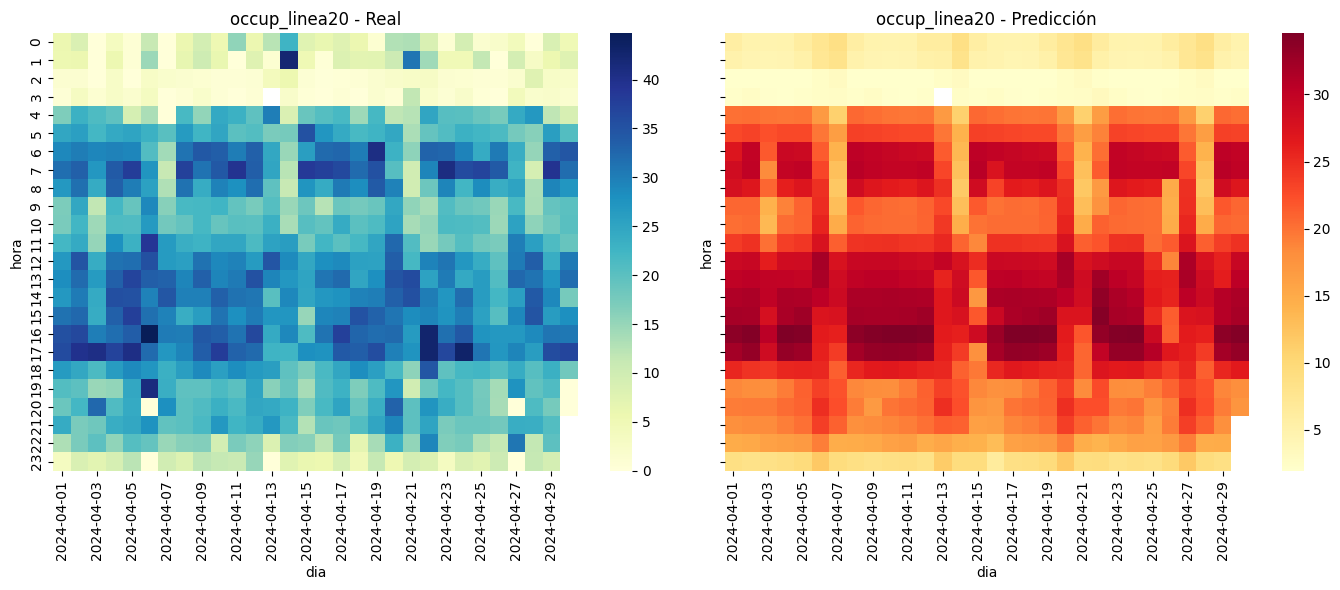

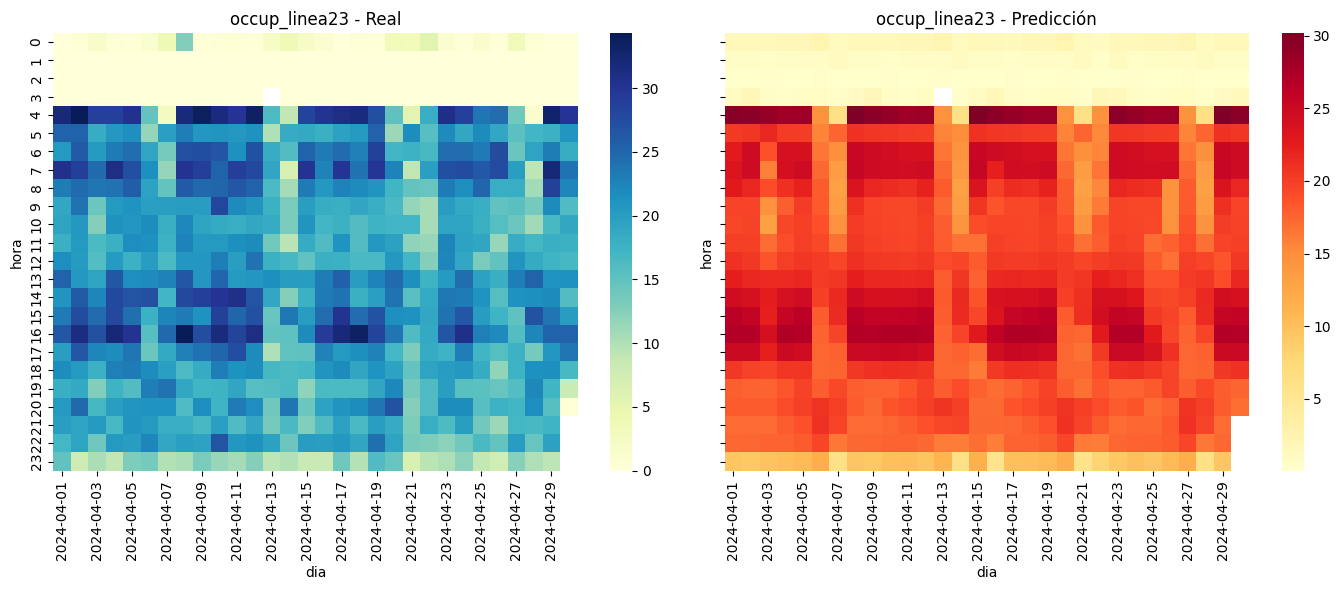

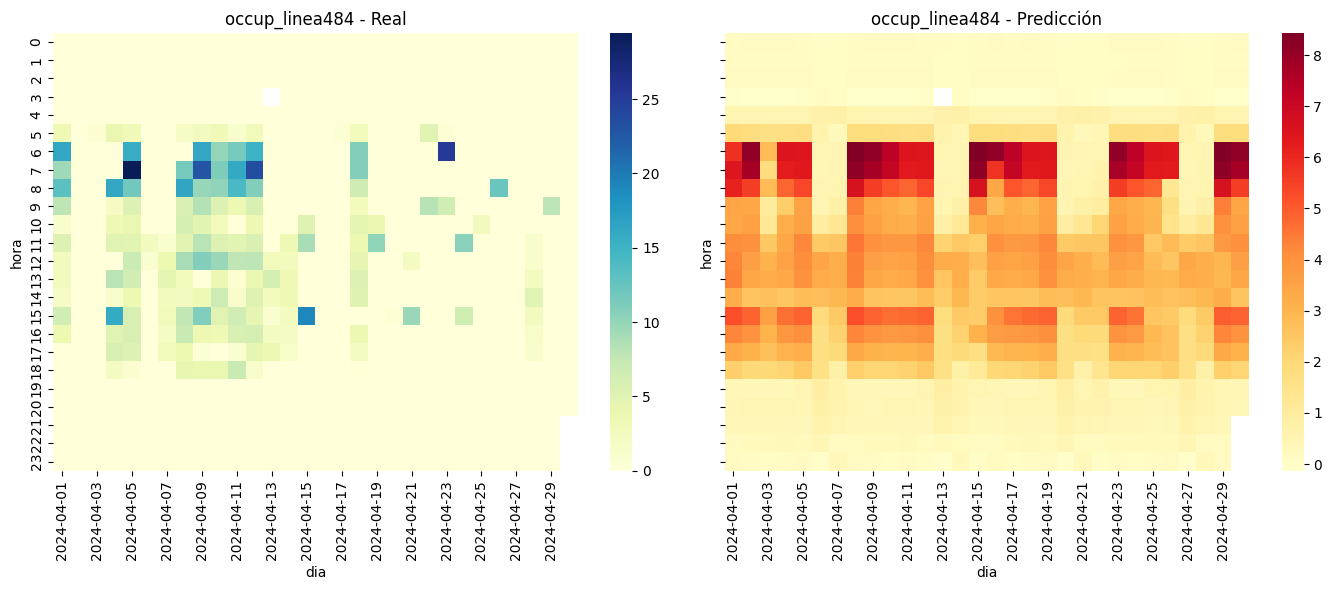

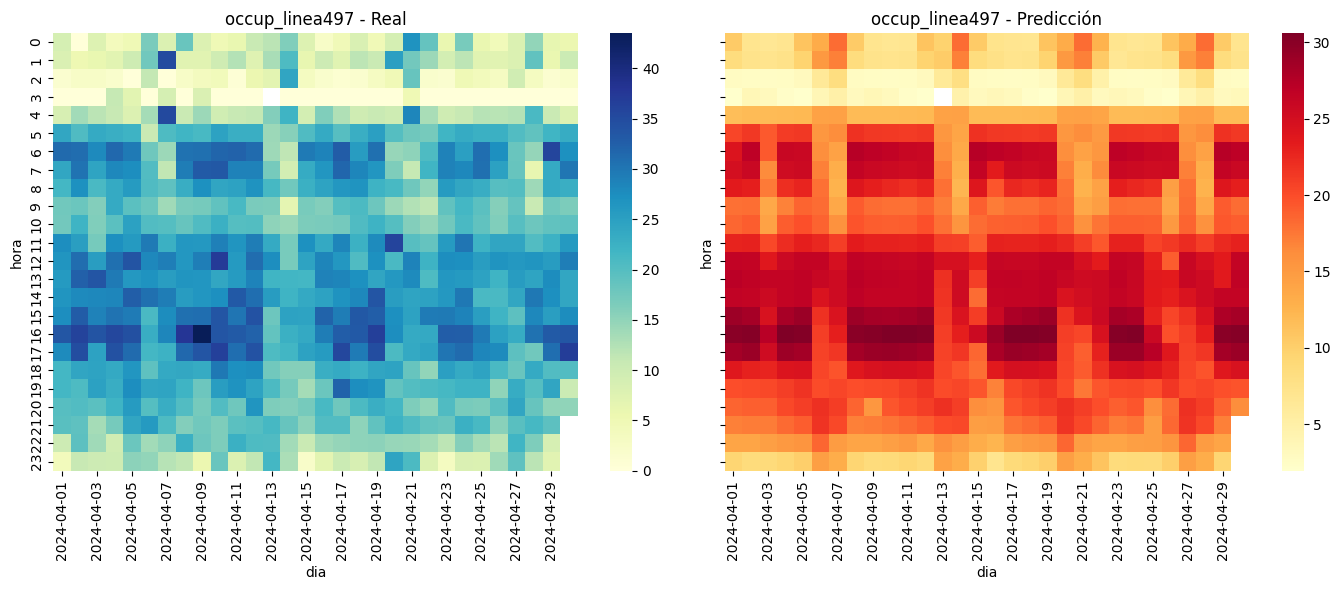

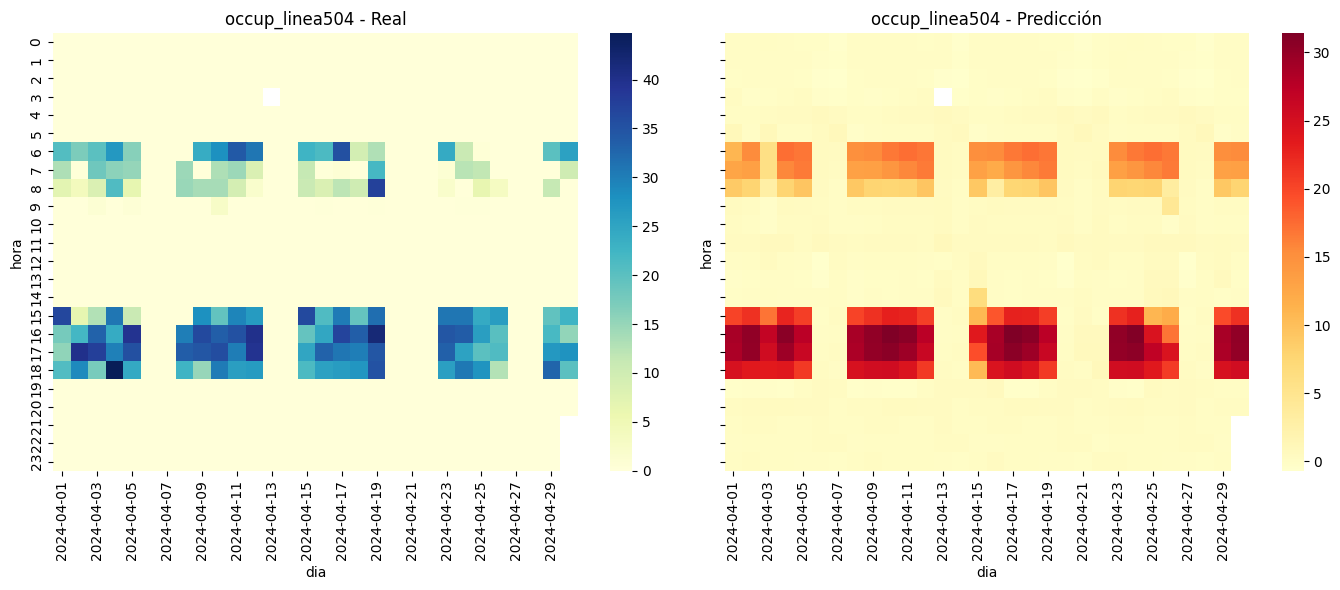

In [ ]:
# Suponiendo que preds contiene las predicciones finales para X_test
preds = final_model.predict(X_test)

# Crear columna de fecha completa si aún no está
df_wide['hora_cerrada_str'] = df_wide['hora_cerrada'].astype(int).astype(str).str.zfill(2) + ':00'
df_wide['fecha_completa'] = pd.to_datetime(df_wide['dia'].astype(str) + ' ' + df_wide['hora_cerrada_str'])

# Filtrar test (mes 4)
df_test = df_wide[df_wide['mes'] == 4].copy()
fecha_test = df_test['fecha_completa'].reset_index(drop=True)

# Para cada línea, graficar reales y predichos lado a lado
for i, linea in enumerate(target_cols):
    y_real = y_test.iloc[:, i].values
    y_pred = preds[:, i]

    tmp_real = pd.DataFrame({
        'fecha': fecha_test,
        'valor': y_real
    })
    tmp_real['hora'] = tmp_real['fecha'].dt.hour
    tmp_real['dia'] = tmp_real['fecha'].dt.date

    tmp_pred = pd.DataFrame({
        'fecha': fecha_test,
        'valor': y_pred
    })
    tmp_pred['hora'] = tmp_pred['fecha'].dt.hour
    tmp_pred['dia'] = tmp_pred['fecha'].dt.date

    tabla_real = tmp_real.pivot_table(index='hora', columns='dia', values='valor')
    tabla_pred = tmp_pred.pivot_table(index='hora', columns='dia', values='valor')

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.heatmap(tabla_real, ax=axes[0], cmap='YlGnBu')
    axes[0].set_title(f'{linea} - Real')
    sns.heatmap(tabla_pred, ax=axes[1], cmap='YlOrRd')
    axes[1].set_title(f'{linea} - Predicción')
    plt.tight_layout()
    plt.show()


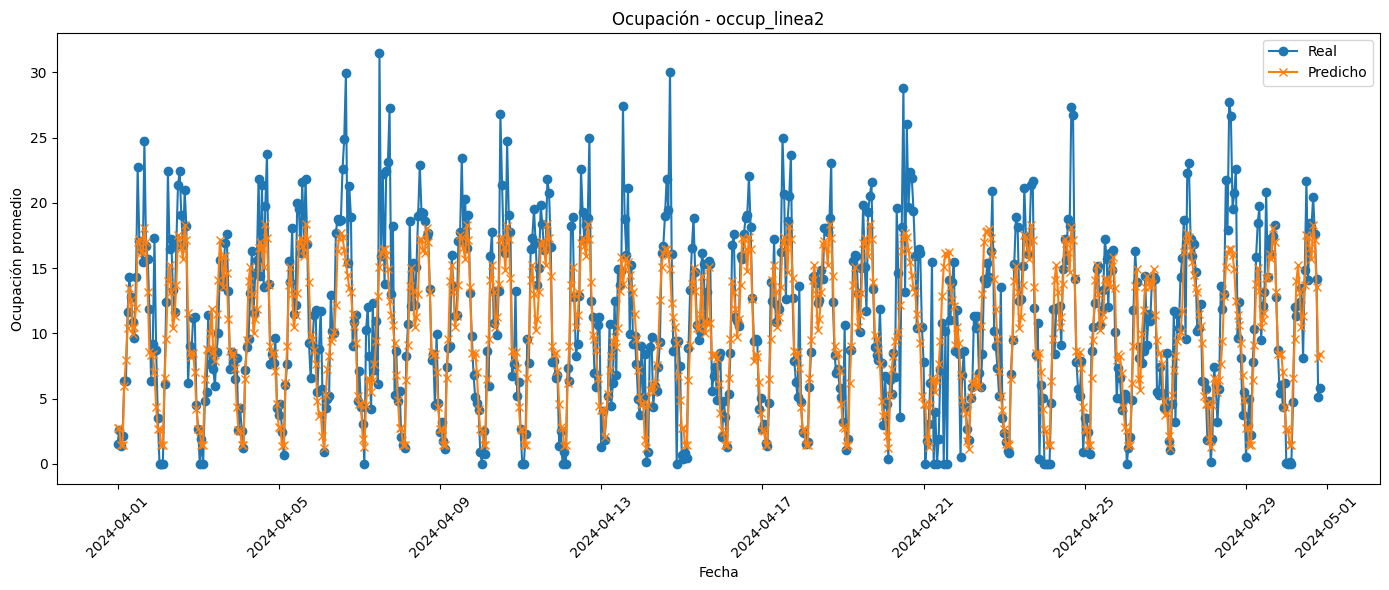

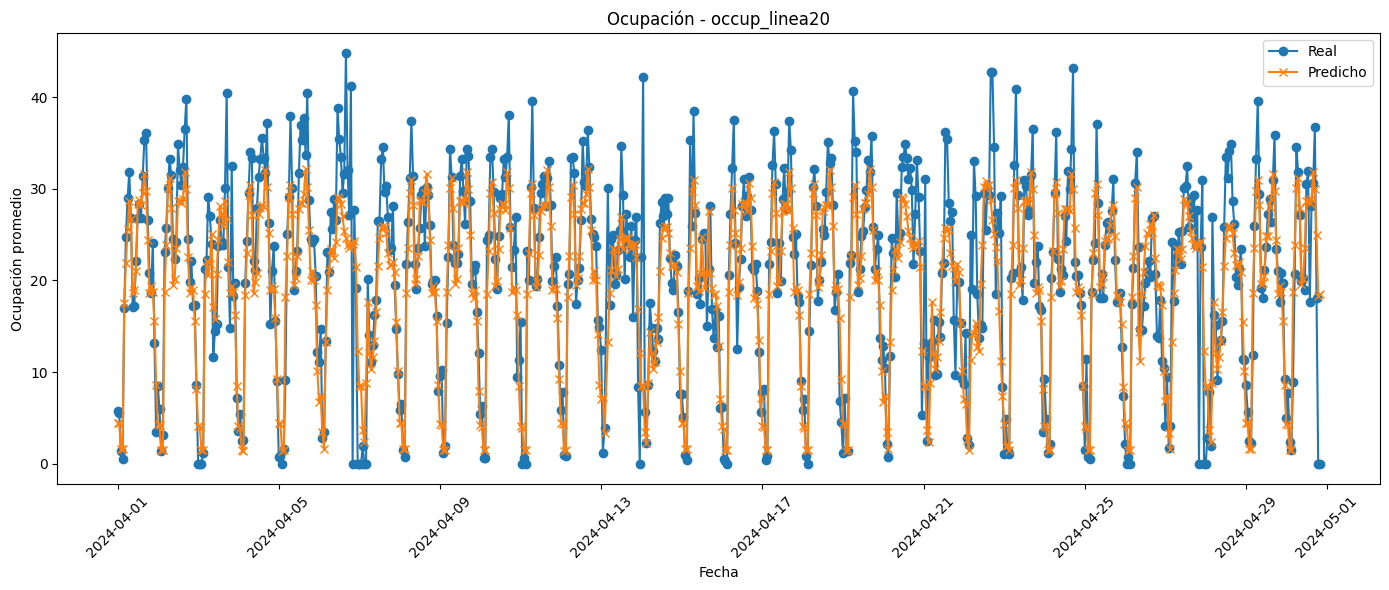

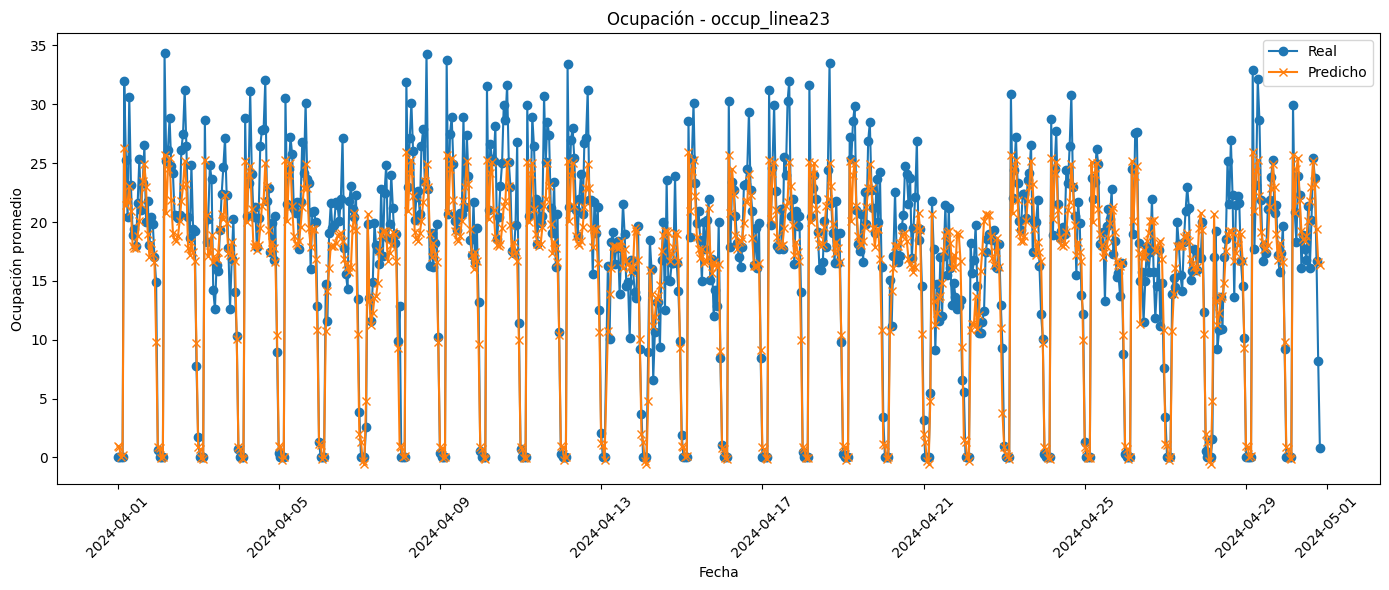

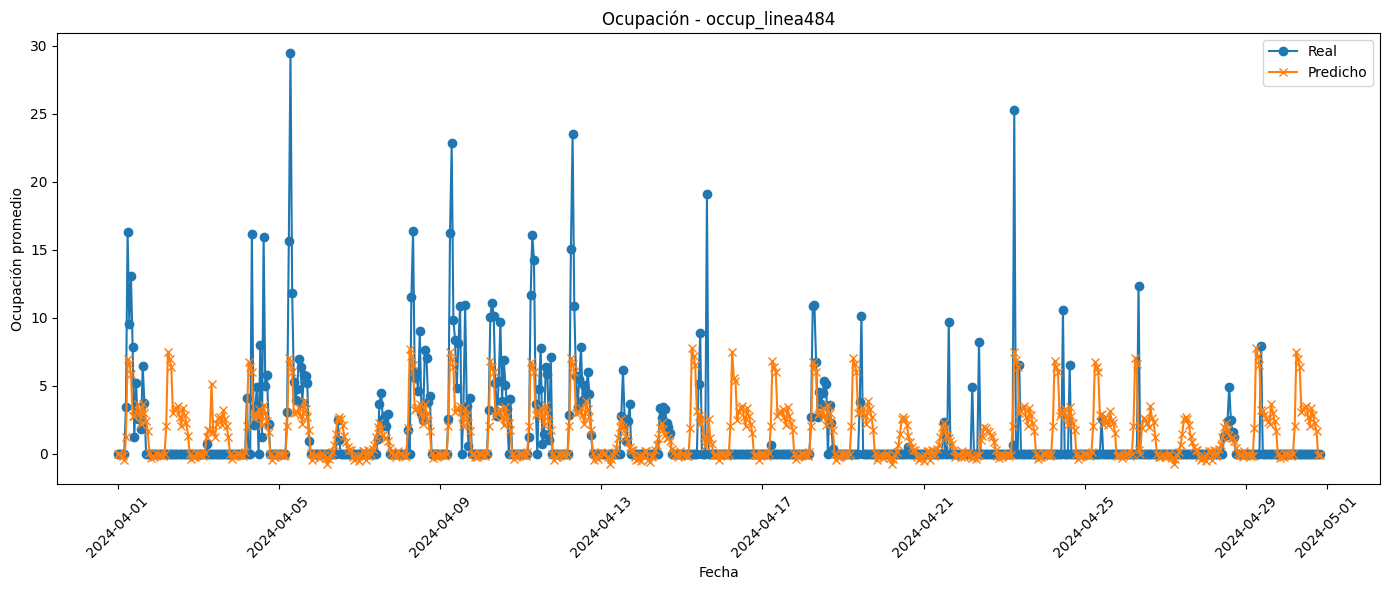

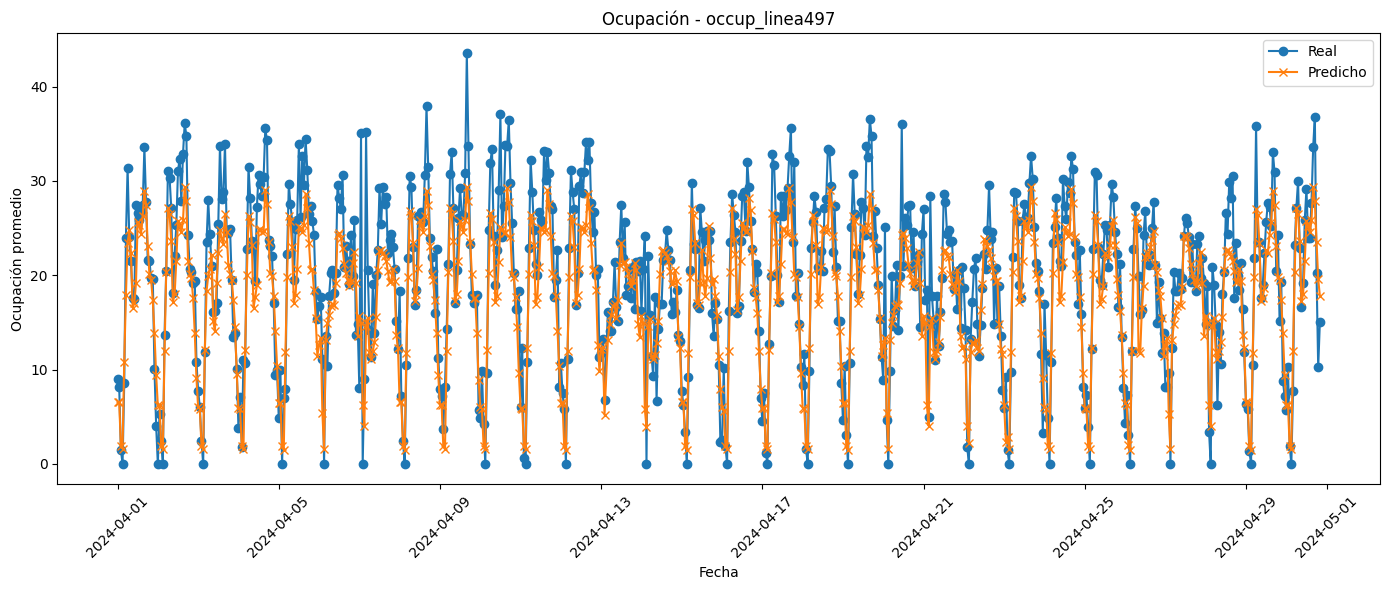

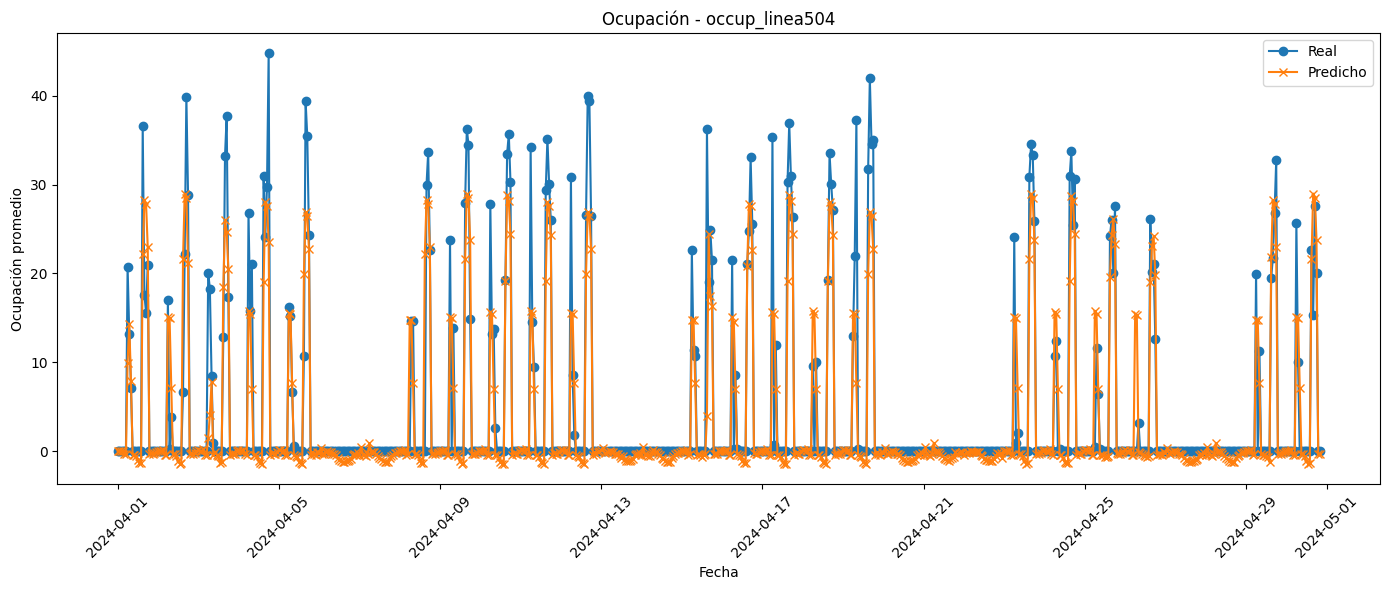

In [ ]:
lineas = y_test.columns  # ['occup_linea370', 'occup_linea405', ...]

for linea in lineas:
    plt.figure(figsize=(14, 6))
    df_plot = resultados[resultados['linea'] == linea]

    # Ordenar por fecha y hora para que el gráfico tenga sentido temporal
    df_plot = df_plot.sort_values(['dia', 'hora'])

    plt.plot(df_plot['fecha'], df_plot['real'], marker='o', label='Real')
    plt.plot(df_plot['fecha'], df_plot['pred'], marker='x', label='Predicho')

    plt.title(f'Ocupación - {linea}')
    plt.xlabel('Fecha')
    plt.ylabel('Ocupación promedio')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


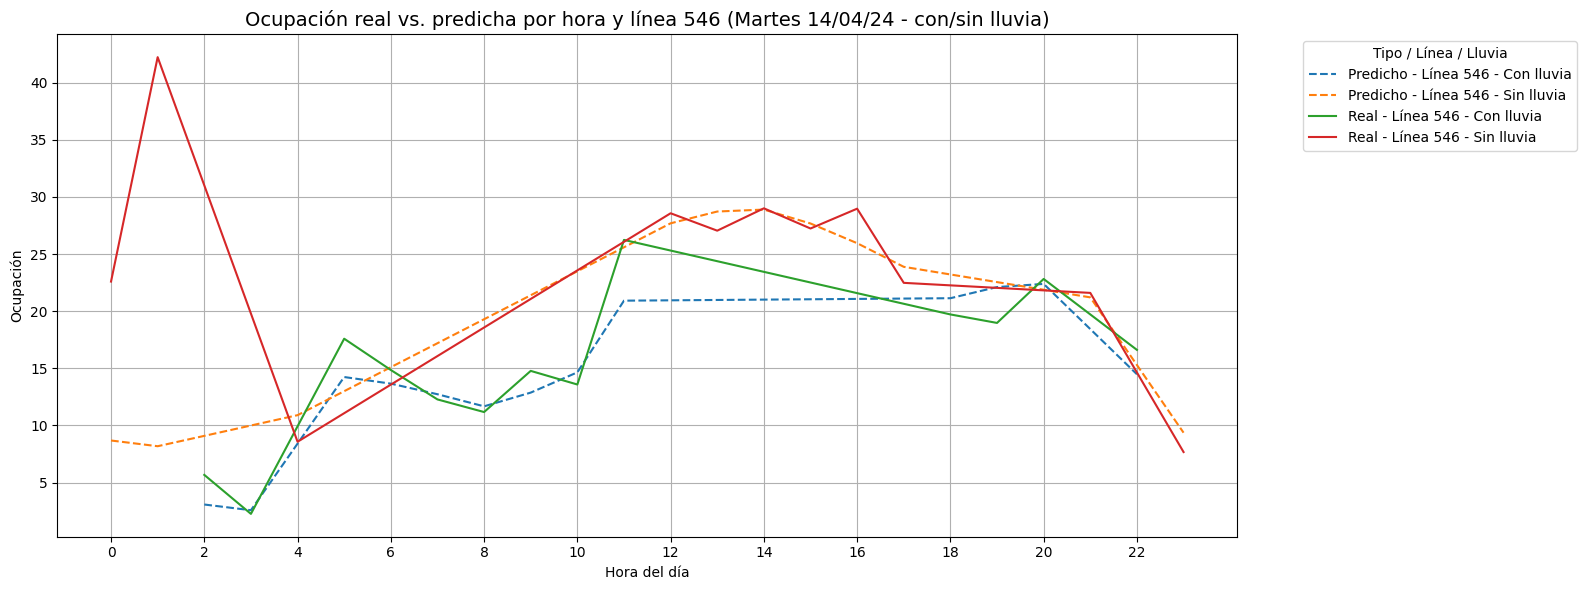

In [ ]:
# Es para el día 09/04/2024, que es domingo

df_resultados = []

for i, linea in enumerate(target_cols):
    y_real = y_test.iloc[:, i].values
    y_pred = preds[:, i]

    df_linea_real = pd.DataFrame({
        'fecha': fecha_test,
        'fecha_completa': fecha_test,
        'linea': linea,
        'hora': fecha_test.dt.hour,
        'dia': fecha_test.dt.date,
        'valor': y_real,
        'tipo': 'Real'
    })

    df_linea_pred = pd.DataFrame({
        'fecha': fecha_test,
        'fecha_completa': fecha_test,
        'linea': linea,
        'hora': fecha_test.dt.hour,
        'dia': fecha_test.dt.date,
        'valor': y_pred,
        'tipo': 'Predicho'
    })

    df_resultados.append(df_linea_real)
    df_resultados.append(df_linea_pred)

df_final = pd.concat(df_resultados)

# Agregar columna lluvia desde df_wide
df_lluvia_info = df_wide[['fecha_completa', 'lluvia']].copy()
df_final = df_final.merge(df_lluvia_info, on='fecha_completa', how='left')

# Filtrar 9 de abril y líneas
df_9_abril = df_final[
    (df_final['fecha'].dt.date == pd.to_datetime('2024-04-14').date()) &
    (df_final['linea'].isin(['occup_linea20']))
    #(df_final['linea'].isin(['occup_linea2', 'occup_linea20']))
].copy()

# Renombrar líneas
df_9_abril['linea'] = df_9_abril['linea'].replace({
    'occup_linea2': 'Línea 404',
    'occup_linea20': 'Línea 546'
})

# Clasificación por lluvia
df_9_abril['cond_lluvia'] = np.where(df_9_abril['lluvia'] > 0, 'Con lluvia', 'Sin lluvia')

# Crear una nueva columna que agrupe tipo + línea + lluvia
df_9_abril['grupo'] = (
    df_9_abril['tipo'] + ' - ' + df_9_abril['linea'] + ' - ' + df_9_abril['cond_lluvia']
)

# Estilo según tipo
estilos = {
    'Real': '-',
    'Predicho': '--'
}

# Graficar
plt.figure(figsize=(16, 6))

for grupo, df_sub in df_9_abril.groupby('grupo'):
    tipo = df_sub['tipo'].iloc[0]
    estilo_linea = estilos[tipo]

    sns.lineplot(
        data=df_sub,
        x='hora',
        y='valor',
        label=grupo,
        linestyle=estilo_linea
    )

plt.title('Ocupación real vs. predicha por hora y línea 546 (Martes 14/04/24 - con/sin lluvia)', fontsize=14)
plt.xlabel('Hora del día')
plt.ylabel('Ocupación')
plt.xticks(range(0, 24, 2))
plt.legend(title='Tipo / Línea / Lluvia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



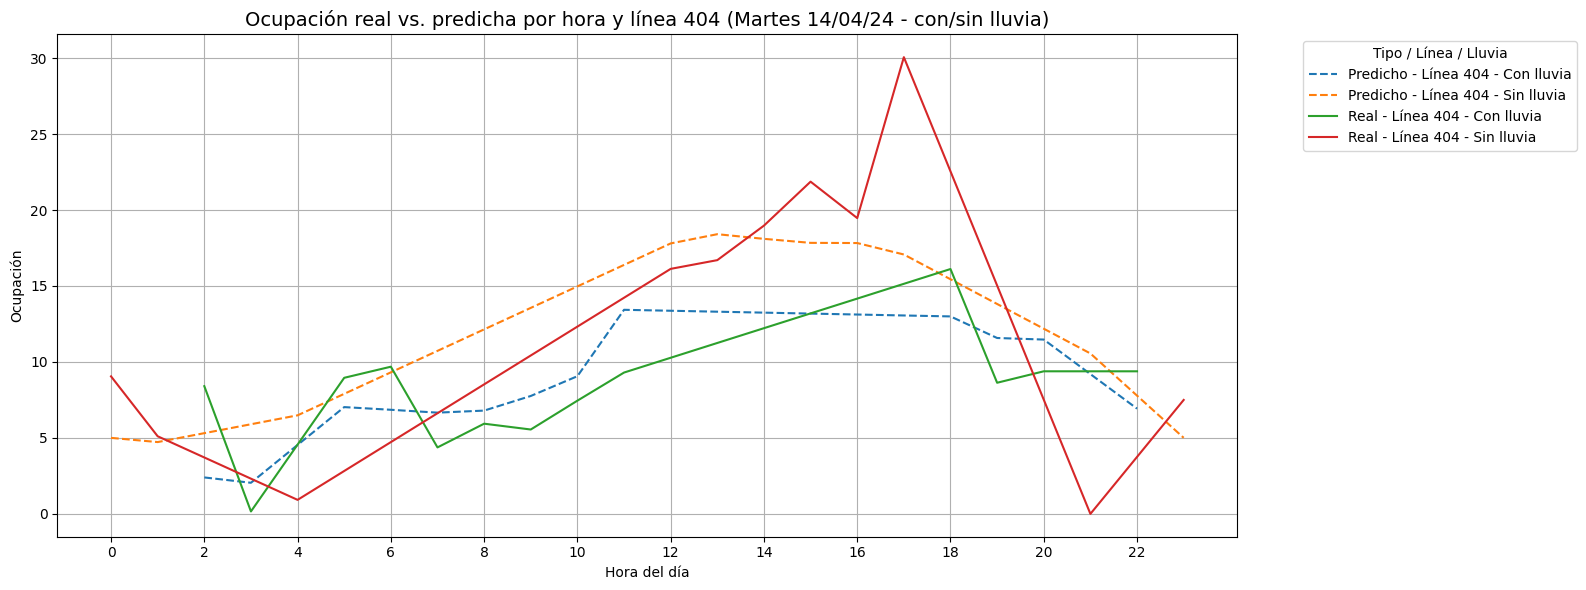

In [ ]:
# Es para el día 14/04/2024, que es domingo

df_resultados = []

for i, linea in enumerate(target_cols):
    y_real = y_test.iloc[:, i].values
    y_pred = preds[:, i]

    df_linea_real = pd.DataFrame({
        'fecha': fecha_test,
        'fecha_completa': fecha_test,
        'linea': linea,
        'hora': fecha_test.dt.hour,
        'dia': fecha_test.dt.date,
        'valor': y_real,
        'tipo': 'Real'
    })

    df_linea_pred = pd.DataFrame({
        'fecha': fecha_test,
        'fecha_completa': fecha_test,
        'linea': linea,
        'hora': fecha_test.dt.hour,
        'dia': fecha_test.dt.date,
        'valor': y_pred,
        'tipo': 'Predicho'
    })

    df_resultados.append(df_linea_real)
    df_resultados.append(df_linea_pred)

df_final = pd.concat(df_resultados)

# Agregar columna lluvia desde df_wide
df_lluvia_info = df_wide[['fecha_completa', 'lluvia']].copy()
df_final = df_final.merge(df_lluvia_info, on='fecha_completa', how='left')

# Filtrar 9 de abril y líneas
df_9_abril = df_final[
    (df_final['fecha'].dt.date == pd.to_datetime('2024-04-14').date()) &
    (df_final['linea'].isin(['occup_linea2']))
    #(df_final['linea'].isin(['occup_linea2', 'occup_linea20']))
].copy()

# Renombrar líneas
df_9_abril['linea'] = df_9_abril['linea'].replace({
    'occup_linea2': 'Línea 404',
    'occup_linea20': 'Línea 546'
})

# Clasificación por lluvia
df_9_abril['cond_lluvia'] = np.where(df_9_abril['lluvia'] > 0, 'Con lluvia', 'Sin lluvia')

# Crear una nueva columna que agrupe tipo + línea + lluvia
df_9_abril['grupo'] = (
    df_9_abril['tipo'] + ' - ' + df_9_abril['linea'] + ' - ' + df_9_abril['cond_lluvia']
)

# Estilo según tipo
estilos = {
    'Real': '-',
    'Predicho': '--'
}

# Graficar
plt.figure(figsize=(16, 6))

for grupo, df_sub in df_9_abril.groupby('grupo'):
    tipo = df_sub['tipo'].iloc[0]
    estilo_linea = estilos[tipo]

    sns.lineplot(
        data=df_sub,
        x='hora',
        y='valor',
        label=grupo,
        linestyle=estilo_linea
    )

plt.title('Ocupación real vs. predicha por hora y línea 404 (Martes 14/04/24 - con/sin lluvia)', fontsize=14)
plt.xlabel('Hora del día')
plt.ylabel('Ocupación')
plt.xticks(range(0, 24, 2))
plt.legend(title='Tipo / Línea / Lluvia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
dias_lluvia.to_list()

[datetime.date(2024, 1, 2),
 datetime.date(2024, 1, 5),
 datetime.date(2024, 1, 6),
 datetime.date(2024, 1, 7),
 datetime.date(2024, 1, 8),
 datetime.date(2024, 1, 14),
 datetime.date(2024, 1, 16),
 datetime.date(2024, 1, 18),
 datetime.date(2024, 1, 19),
 datetime.date(2024, 1, 31),
 datetime.date(2024, 2, 6),
 datetime.date(2024, 2, 7),
 datetime.date(2024, 2, 8),
 datetime.date(2024, 2, 9),
 datetime.date(2024, 2, 10),
 datetime.date(2024, 2, 11),
 datetime.date(2024, 2, 12),
 datetime.date(2024, 2, 13),
 datetime.date(2024, 2, 16),
 datetime.date(2024, 2, 17),
 datetime.date(2024, 2, 18),
 datetime.date(2024, 2, 19),
 datetime.date(2024, 2, 25),
 datetime.date(2024, 2, 26),
 datetime.date(2024, 2, 27),
 datetime.date(2024, 3, 2),
 datetime.date(2024, 3, 3),
 datetime.date(2024, 3, 5),
 datetime.date(2024, 3, 8),
 datetime.date(2024, 3, 9),
 datetime.date(2024, 3, 10),
 datetime.date(2024, 3, 11),
 datetime.date(2024, 3, 12),
 datetime.date(2024, 3, 13),
 datetime.date(2024, 3, 14),

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


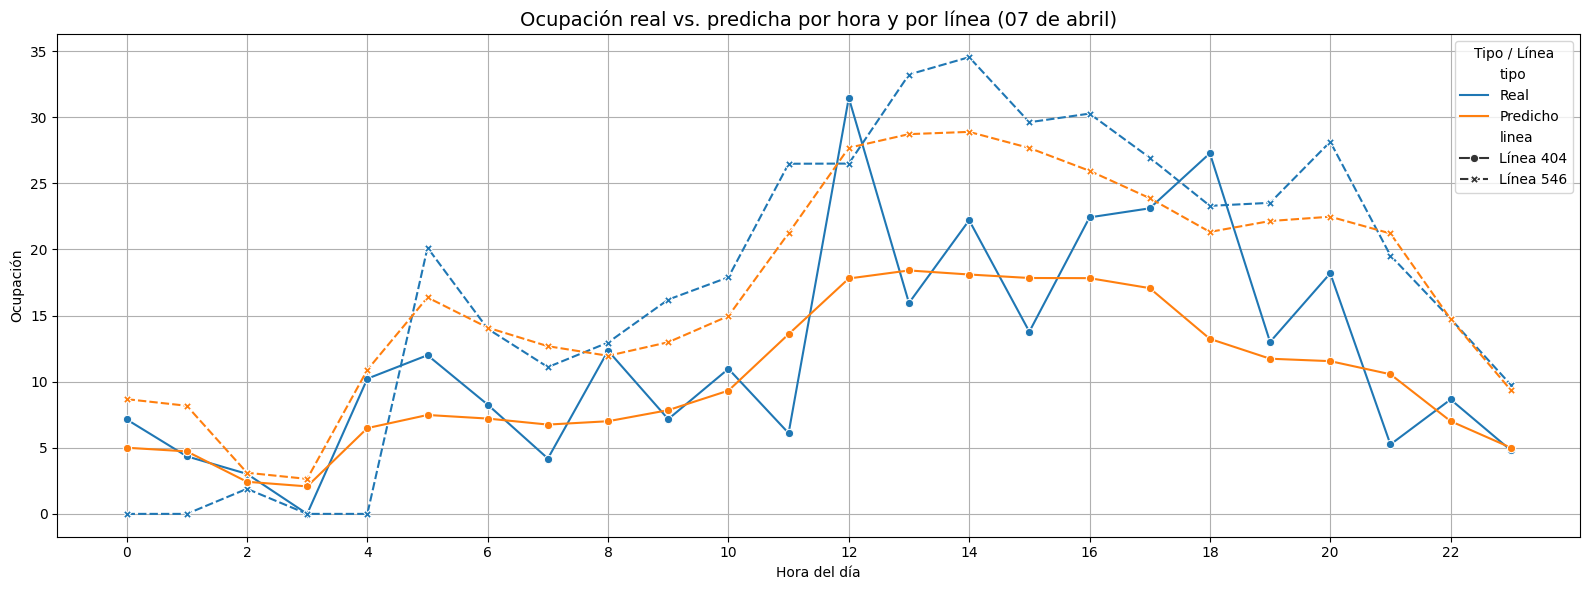

In [ ]:
# Es para el día 07/04/2024, que es domingo
# Generar predicciones
preds = final_model.predict(X_test)

# Reconstruir fechas en test
df_wide['hora_cerrada_str'] = df_wide['hora_cerrada'].astype(int).astype(str).str.zfill(2) + ':00'
df_wide['fecha_completa'] = pd.to_datetime(df_wide['dia'].astype(str) + ' ' + df_wide['hora_cerrada_str'])

df_test = df_wide[df_wide['mes'] == 4].copy()
fecha_test = df_test['fecha_completa'].reset_index(drop=True)

# Armar DataFrame largo con reales y predichos
df_resultados = []

for i, linea in enumerate(target_cols):
    y_real = y_test.iloc[:, i].values
    y_pred = preds[:, i]

    df_linea_real = pd.DataFrame({
        'fecha': fecha_test,
        'linea': linea,
        'hora': fecha_test.dt.hour,
        'dia': fecha_test.dt.date,
        'valor': y_real,
        'tipo': 'Real'
    })

    df_linea_pred = pd.DataFrame({
        'fecha': fecha_test,
        'linea': linea,
        'hora': fecha_test.dt.hour,
        'dia': fecha_test.dt.date,
        'valor': y_pred,
        'tipo': 'Predicho'
    })

    df_resultados.append(df_linea_real)
    df_resultados.append(df_linea_pred)

df_final = pd.concat(df_resultados)

# Filtrar solo 7 de abril
df_8_abril = df_final[
    (df_final['fecha'].dt.date == pd.to_datetime('2024-04-07').date()) &
    (df_final['linea'].isin(['occup_linea2', 'occup_linea20']))
].copy()

df_8_abril['linea'] = df_8_abril['linea'].replace({
    'occup_linea2': 'Línea 404',
    'occup_linea20': 'Línea 546'
})

# Gráfico
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_8_abril, x='hora', y='valor', hue='tipo', style='linea', markers=True)
plt.title('Ocupación real vs. predicha por hora y por línea (07 de abril)', fontsize=14)
plt.xlabel('Hora del día')
plt.ylabel('Ocupación')
plt.xticks(range(0, 24, 2))
plt.legend(title='Tipo / Línea')
plt.grid(True)
plt.tight_layout()
plt.show()
